# Descarga y Normalización de Datos

Este cuaderno tiene como objetivo principal la **descarga** y la **normalización** de los datos requeridos para el análisis.

En caso de que los datos descargados necesiten ser procesados o normalizados, este apartado incluye las funciones necesarias para:
- Eliminar valores nulos o inconsistentes.
- Interpolar o extrapolar los datos a un rango específico.
- Transformar las variables para facilitar el análisis posterior.
- Identificar cada celda de la región.

Este proceso asegura que los datos estén en un formato adecuado para su uso en modelos o visualizaciones.

### Paso previo: importación de las librerías necesarias

In [1]:
import os
import copernicusmarine
import xarray as xr
import numpy as np
import pandas as pd
import requests
import gzip
import shutil
from datetime import datetime, timedelta
from netCDF4 import Dataset
import glob
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from cftime import date2num

### 1. Descarga y normalización de datos de Clorofila y Fitoplancton

En este apartado, se realiza la descarga de los datos de clorofila y tipos de titoplancton, utilizando la función `subset` de la librería `copernicusmarine`. Los datos se almacenan en la carpeta `Datos/Chlorophyll` dentro del directorio del proyecto. Antes de la descarga, se verifica que la carpeta de destino exista; de lo contrario, se crea automáticamente.

In [ ]:
output_dir = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Chlorophyll"
os.makedirs(output_dir, exist_ok=True)

def download_CHL_phyto_data():
    copernicusmarine.subset(
        dataset_id="cmems_obs-oc_glo_bgc-plankton_my_l4-multi-4km_P1M",
        variables=["DIATO_uncertainty", "DINO", "DINO_uncertainty", "GREEN", "GREEN_uncertainty", "HAPTO", "HAPTO_uncertainty", "MICRO", "MICRO_uncertainty", "NANO", "NANO_uncertainty", "PICO", "PICO_uncertainty", "PROCHLO", "PROCHLO_uncertainty", "PROKAR", "PROKAR_uncertainty", "flags", "DIATO", "CHL_uncertainty", "CHL"],
        minimum_longitude=-27,
        maximum_longitude=-7,
        minimum_latitude=13,
        maximum_latitude=33,
        start_datetime="1997-09-01T00:00:00",
        end_datetime="2025-02-01T00:00:00",
        output_directory=r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Chlorophyll"
    )

download_CHL_phyto_data()

A continuación, se asignará un ID para cada punto (lat, lon) de la cuadrícula, ignorando el tiempo:

In [ ]:
# Carga el NetCDF
directory = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Chlorophyll\cmems_obs-oc_glo_bgc-plankton_my_l4-multi-4km_P1M_multi-vars_26.98W-7.02W_13.02N-32.98N_1997-09-01-2025-02-01.nc"
ds = xr.open_dataset(directory)

# Creamos un array con IDs únicos para cada (lat, lon)
lat_len = ds.sizes["latitude"]
lon_len = ds.sizes["longitude"]

# Creamos un array de IDs secuenciales
grid_ids = np.arange(lat_len * lon_len).reshape((lat_len, lon_len))

# Añadir el ID como nueva variable
ds["grid_id"] = (("latitude", "longitude"), grid_ids)
ds["grid_id"].attrs["long_name"] = "Unique ID per grid cell"

# Guardamos en un nuevo archivo
ds.to_netcdf(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Chlorophyll\chlorophyll_with_grid_ids.nc")

In [ ]:
# Ruta al archivo original
archivo_entrada = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Chlorophyll\chlorophyll_with_grid_ids.nc"

# Ruta para guardar el nuevo archivo
archivo_salida = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Chlorophyll\chlorophyll_with_grid_ids_v1.nc"

# Abrir el dataset original
ds = xr.open_dataset(archivo_entrada)

# Lista de variables que quieres conservar
variables_deseadas = [
    'grid_id',
    'CHL',
    'DIATO',
    'DINO',
    'GREEN',
    'HAPTO',
    'MICRO',
    'NANO',
    'PICO',
    'PROCHLO',
    'PROKAR'
]

# Seleccionar solo las variables deseadas
ds_filtrado = ds[variables_deseadas]

# Crear las nuevas coordenadas de tiempo (convertir a días desde 1900-01-01)
# Convertir 'time' a un formato de fecha en el que se basen los días desde 1900-01-01
base_time = pd.to_datetime('1900-01-01')

# Asegurarse de que 'time' es un array de numpy y que las unidades de tiempo son correctas
time_values = pd.to_datetime(ds_filtrado['time'].values, unit='D')

# Calcular la diferencia en días desde 1900-01-01
time_days = (time_values - base_time).days

# Reemplazar la variable 'time' con la nueva en formato float32
ds_filtrado['time'] = (('time',), time_days.astype('float32'))

# Añadir atributos a la variable 'time'
ds_filtrado['time'].attrs = {
    '_FillValue': float('NaN'),  # Añadir el valor de relleno NaN
    'axis': 'T',                 # Eje temporal
    'long_name': 'Time',         # Nombre largo de la variable
    'unit_long': 'Days Since 1900-01-01',  # Unidad larga
    'standard_name': 'time',     # Nombre estándar
    'units': 'days since 1900-01-01',  # Unidad
    'calendar': 'Gregorian'      # Calendario utilizado
}

# Convertir las coordenadas 'longitude' y 'latitude' a float32
ds_filtrado['longitude'] = ds_filtrado['longitude'].astype('float32')
ds_filtrado['latitude'] = ds_filtrado['latitude'].astype('float32')

# Añadir los atributos adecuados a las coordenadas 'longitude' y 'latitude'
ds_filtrado['longitude'].attrs = {
    '_FillValue': float('NaN'),
    'units': 'degrees_east',
    'standard_name': 'longitude',
    'axis': 'X'
}

ds_filtrado['latitude'].attrs = {
    '_FillValue': float('NaN'),
    'units': 'degrees_north',
    'standard_name': 'latitude',
    'axis': 'Y'
}

# Crear un nuevo archivo NetCDF con las modificaciones
ds_filtrado.to_netcdf(archivo_salida)

print(f"✅ Nuevo archivo NetCDF guardado como: {archivo_salida}")


### 2. Descarga y normalización de datos de Producción Primaria

En este apartado, se realiza la descarga de los datos de producción primaria utilizando un script de descarga automática de los archivos desde [ORCA Oregon State](http://orca.science.oregonstate.edu/npp_products.php), y un ejecutable para la conversión de estos de formato HDF a NetCDF. Los datos se almacenan en la carpeta `Datos/NPP` dentro del directorio del proyecto, y posteriormente, se acoplan unos a otros. Se tratará de actualizar las cabeceras para darles un formato común a los anteriores conjuntos.

El siguiente bloque de código será el encargado de descargar los datos desde enero de 2012 a febrero de 2024 con el sensor VIIRS y el modelo Eppley-VGPM, convertirlos a NetCDF, juntarlos y almacenarlos:

In [ ]:
# Función para descargar la funcionalidad para convertir archivos
def download_functionality():
    url = "https://hdfeos.org/software/h4cflib/previous_releases/1.1/windows/h4tonccf_nc4.exe"
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open("h4tonccf_nc4.exe", 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
        print("Descargado: h4tonccf_nc4.exe")
    else:
        print(f"Error al descargar {url}: Código {response.status_code}")

# Función para descargar archivos .hdf.gz
def download_file(url, output_path):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(output_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
        print(f"Descargado: {output_path}")
    else:
        print(f"Error al descargar {url}: Código {response.status_code}")

# Función para descomprimir el archivo descargado
def decompress_file(gz_path, output_path):
    with gzip.open(gz_path, 'rb') as gz_file:
        with open(output_path, 'wb') as out_file:
            shutil.copyfileobj(gz_file, out_file)
    print(f"Descomprimido: {output_path}")

# Función para convertir el archivo HDF a un archivo NetCDF (como el resto manejados)
def convert_hdf_to_nc(hdf_path, nc_path):
    command = f"h4tonccf_nc4 {hdf_path} {nc_path}"
    os.system(command)
    print(f"Convertido a NetCDF: {nc_path}")

# Función para seleccionar el rango de longitud y latitud definido (Canarias, Azores, Cabo Verde)
def select_lon_lat_range(nc_path, output_path, lon_min, lon_max, lat_min, lat_max, time_value):
    # Abrir el archivo NetCDF
    with Dataset(nc_path, 'r') as nc_file:
        # Obtener datos NPP
        npp_data = nc_file.variables['npp'][:]  # Variable de interés
        # Obtener dimensión 0 (eje y)
        dim0_size = nc_file.dimensions['fakeDim0'].size
        # Obtener dimensión 1 (eje x)
        dim1_size = nc_file.dimensions['fakeDim1'].size

        # Límites globales
        lat_min_global, lat_max_global = -90.0, 90.0
        lon_min_global, lon_max_global = -180.0, 180.0

        # Coordenadas de latitud y longitud
        lat = np.linspace(lat_max_global, lat_min_global, dim0_size)
        lon = np.linspace(lon_min_global, lon_max_global, dim1_size)

        # Encontrar los índices del rango de longitud y latitud
        lon_indices = np.where((lon >= lon_min) & (lon <= lon_max))[0]
        lat_indices = np.where((lat >= lat_min) & (lat <= lat_max))[0]

        # Crear una máscara para los valores fuera del rango
        mask = np.ones_like(npp_data, dtype=bool)  # Máscara inicial (True = fuera del rango)
        mask[np.ix_(lat_indices, lon_indices)] = False  # False = dentro del rango

        # Aplicar la máscara a los datos
        npp_data_masked = np.ma.masked_array(npp_data, mask=mask)

        # Seleccionar el subconjunto de datos
        npp_subset = npp_data_masked[lat_indices, :][:, lon_indices]
        lon_subset = lon[lon_indices]
        lat_subset = lat[lat_indices]

        # Crear un nuevo archivo NetCDF con el subconjunto de datos
        with Dataset(output_path, 'w', format='NETCDF4') as new_nc_file:
            # Crear dimensiones
            new_nc_file.createDimension('time', 1)  # Dimensión temporal (ilimitada)
            new_nc_file.createDimension('lat', len(lat_subset))
            new_nc_file.createDimension('lon', len(lon_subset))

            # Crear variables
            new_time = new_nc_file.createVariable('time', 'f8', ('time',))
            new_lat = new_nc_file.createVariable('lat', lat.dtype, ('lat',))
            new_lon = new_nc_file.createVariable('lon', lon.dtype, ('lon',))
            new_npp = new_nc_file.createVariable('npp', npp_data.dtype, ('time', 'lat', 'lon'), fill_value=-9999.0)

            # Asignar datos
            new_time[:] = [time_value]
            new_lat[:] = lat_subset
            new_lon[:] = lon_subset
            new_npp[:] = npp_subset.filled(-9999.0)  # Rellenar valores enmascarados con -9999.0

            # Definir atributos para la variable de tiempo
            new_time.setncattr('units', 'days since 2012-01-01 00:00:00')  # Fecha de referencia
            new_time.setncattr('long_name', 'time')
            new_time.setncattr('calendar', 'gregorian')  # Calendario gregoriano

            # Copiar atributos (opcional)
            for attr in nc_file.variables['npp'].__dict__:
                new_npp.setncattr(attr, nc_file.variables['npp'].getncattr(attr))

    print(f"Subconjunto guardado en: {output_path}")

# Función para concatenar archivos NetCDF en un solo archivo separado por las fechas
def concatenate_files(file_paths, output_path):
    # Abrir los archivos NetCDF
    datasets = [xr.open_dataset(file) for file in file_paths]

    # Concatenar los archivos en un solo archivo por la dimensión 'time'
    combined_dataset = xr.concat(datasets, dim='time')

    # Guardar el archivo concatenado en un solo archivo NetCDF
    combined_dataset.to_netcdf(output_path)

    print(f"Archivos concatenados guardados en: {output_path}")

# Función principal
def main():

    # Descargar la funcionalidad para convertir archivos
    download_functionality()

    base_url = "http://orca.science.oregonstate.edu/data/2x4/monthly/eppley.r2022.v.chl.v.sst/hdf/"
    start_date = datetime(2012, 1, 1)  # Fecha inicial: enero de 2012
    end_date = datetime(2024, 2, 1)    # Fecha final: enero de 2024
    no_date = datetime(2022, 4, 1)     # Fecha sin datos

    # Rango de longitud y latitud
    lon_min, lon_max = -27, -7
    lat_min, lat_max = 13, 33

    # Lista para almacenar las rutas de los archivos NetCDF
    subset_files = []

    current_date = start_date

    while current_date <= end_date:
    
        """
        # Verificar si la fecha actual es la fecha sin datos
        if current_date == no_date:
            print(f"No hay datos disponibles para {current_date.strftime('%Y-%m-%d')}")
            # Avanzar al siguiente mes
            if current_date.month == 12:
                current_date = current_date.replace(year=current_date.year + 1, month=1)
            else:
                current_date = current_date.replace(month=current_date.month + 1)
            continue
        """

        # Generar el nombre del archivo
        year = current_date.year
        day_of_year = current_date.timetuple().tm_yday
        file_name = f"eppley.{year}{day_of_year:03d}.hdf.gz"
        file_url = base_url + file_name

        # if current_date == no_date:
        #     print(f"No hay datos disponibles para {current_date.strftime('%Y-%m-%d')}")
        #     current_date += timedelta(days=30)
        #     continue

        # Rutas de archivos
        gz_path = file_name
        hdf_path = gz_path.replace(".gz", "")
        nc_path = hdf_path.replace(".hdf", ".nc")
        subset_nc_path = nc_path.replace(".nc", "_subset.nc")

        # Descargar el archivo
        download_file(file_url, gz_path)

        # Descomprimir el archivo
        decompress_file(gz_path, hdf_path)

        # Convertir el archivo HDF a NetCDF
        convert_hdf_to_nc(hdf_path, nc_path)

        # Calcular el valor de tiempo en días desde la fecha de referencia (2012-01-01)
        time_value = (current_date - start_date).days

        # Seleccionar el rango de longitud y latitud
        select_lon_lat_range(nc_path, subset_nc_path, lon_min, lon_max, lat_min, lat_max, time_value)

        # Agregar el archivo subset a la lista
        subset_files.append(subset_nc_path)

        # Eliminar archivos temporales (opcional)
        os.remove(gz_path)
        os.remove(hdf_path)
        os.remove(nc_path)

        # Avanzar al siguiente mes
        if current_date.month == 12:
            current_date = current_date.replace(year=current_date.year + 1, month=1)
        else:
            current_date = current_date.replace(month=current_date.month + 1)

    print(subset_files)

    # Concatenar todos los archivos subset en uno solo
    output_dir = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\NPP\def\eppley.2012to2024_subset.nc"
    concatenate_files(subset_files, output_dir)

    # Eliminar los archivos subset
    for file in subset_files:
        os.remove(file)

if __name__ == "__main__":
    main()

El siguiente bloque de código será el encargado de descargar los datos desde octubre de 1997 a junio de 2002 con el sensor SeaWiFS y el modelo Eppley-VGPM, convertirlos a NetCDF, juntarlos y almacenarlos:

In [ ]:
# Función para descargar archivos .hdf.gz
def download_file(url, output_path):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(output_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
        print(f"Descargado: {output_path}")
    else:
        print(f"Error al descargar {url}: Código {response.status_code}")

# Función para descomprimir el archivo descargado
def decompress_file(gz_path, output_path):
    with gzip.open(gz_path, 'rb') as gz_file:
        with open(output_path, 'wb') as out_file:
            shutil.copyfileobj(gz_file, out_file)
    print(f"Descomprimido: {output_path}")

# Función para convertir el archivo HDF a un archivo NetCDF (como el resto manejados)
def convert_hdf_to_nc(hdf_path, nc_path):
    command = f"h4tonccf_nc4 {hdf_path} {nc_path}"
    os.system(command)
    print(f"Convertido a NetCDF: {nc_path}")

# Función para seleccionar el rango de longitud y latitud definido (Canarias, Azores, Cabo Verde)
def select_lon_lat_range(nc_path, output_path, lon_min, lon_max, lat_min, lat_max, time_value):
    # Abrir el archivo NetCDF
    with Dataset(nc_path, 'r') as nc_file:
        # Obtener datos NPP
        npp_data = nc_file.variables['npp'][:]  # Variable de interés
        # Obtener dimensión 0 (eje y)
        dim0_size = nc_file.dimensions['fakeDim0'].size
        # Obtener dimensión 1 (eje x)
        dim1_size = nc_file.dimensions['fakeDim1'].size

        # Límites globales
        lat_min_global, lat_max_global = -90.0, 90.0
        lon_min_global, lon_max_global = -180.0, 180.0

        # Coordenadas de latitud y longitud
        lat = np.linspace(lat_max_global, lat_min_global, dim0_size)
        lon = np.linspace(lon_min_global, lon_max_global, dim1_size)

        # Encontrar los índices del rango de longitud y latitud
        lon_indices = np.where((lon >= lon_min) & (lon <= lon_max))[0]
        lat_indices = np.where((lat >= lat_min) & (lat <= lat_max))[0]

        # Crear una máscara para los valores fuera del rango
        mask = np.ones_like(npp_data, dtype=bool)  # Máscara inicial (True = fuera del rango)
        mask[np.ix_(lat_indices, lon_indices)] = False  # False = dentro del rango

        # Aplicar la máscara a los datos
        npp_data_masked = np.ma.masked_array(npp_data, mask=mask)

        # Seleccionar el subconjunto de datos
        npp_subset = npp_data_masked[lat_indices, :][:, lon_indices]
        lon_subset = lon[lon_indices]
        lat_subset = lat[lat_indices]

        # Crear un nuevo archivo NetCDF con el subconjunto de datos
        with Dataset(output_path, 'w', format='NETCDF4') as new_nc_file:
            # Crear dimensiones
            new_nc_file.createDimension('time', 1)  # Dimensión temporal (ilimitada)
            new_nc_file.createDimension('lat', len(lat_subset))
            new_nc_file.createDimension('lon', len(lon_subset))

            # Crear variables
            new_time = new_nc_file.createVariable('time', 'f8', ('time',))
            new_lat = new_nc_file.createVariable('lat', lat.dtype, ('lat',))
            new_lon = new_nc_file.createVariable('lon', lon.dtype, ('lon',))
            new_npp = new_nc_file.createVariable('npp', npp_data.dtype, ('time', 'lat', 'lon'), fill_value=-9999.0)

            # Asignar datos
            new_time[:] = [time_value]
            new_lat[:] = lat_subset
            new_lon[:] = lon_subset
            new_npp[:] = npp_subset.filled(-9999.0)  # Rellenar valores enmascarados con -9999.0

            # Definir atributos para la variable de tiempo
            new_time.setncattr('units', 'days since 1997-10-01 00:00:00')  # Fecha de referencia
            new_time.setncattr('long_name', 'time')
            new_time.setncattr('calendar', 'gregorian')  # Calendario gregoriano

            # Copiar atributos (opcional)
            for attr in nc_file.variables['npp'].__dict__:
                new_npp.setncattr(attr, nc_file.variables['npp'].getncattr(attr))

    print(f"Subconjunto guardado en: {output_path}")

# Función para concatenar archivos NetCDF en un solo archivo separado por las fechas
def concatenate_files(file_paths, output_path):
    # Abrir los archivos NetCDF
    datasets = [xr.open_dataset(file) for file in file_paths]

    # Concatenar los archivos en un solo archivo por la dimensión 'time'
    combined_dataset = xr.concat(datasets, dim='time')

    # Guardar el archivo concatenado en un solo archivo NetCDF
    combined_dataset.to_netcdf(output_path)

    print(f"Archivos concatenados guardados en: {output_path}")

# Función principal
def main():

    base_url = "http://orca.science.oregonstate.edu/data/1x2/monthly/eppley.r2014.s.chl.a.sst/hdf/"
    start_date = datetime(1997, 10, 1)  # Fecha inicial: octubre de 1997
    # end_date = datetime(2002, 6, 1)    # Fecha final: enero de 2024
    end_date = datetime(2002, 6, 1)    # Fecha final: enero de 2024

    # Rango de longitud y latitud
    lon_min, lon_max = -27, -7
    lat_min, lat_max = 13, 33

    # Lista para almacenar las rutas de los archivos NetCDF
    subset_files = []

    current_date = start_date

    while current_date <= end_date:

        # Generar el nombre del archivo
        year = current_date.year
        day_of_year = current_date.timetuple().tm_yday
        file_name = f"eppley.{year}{day_of_year:03d}.hdf.gz"
        file_url = base_url + file_name

        # Rutas de archivos
        gz_path = file_name
        hdf_path = gz_path.replace(".gz", "")
        nc_path = hdf_path.replace(".hdf", ".nc")
        subset_nc_path = nc_path.replace(".nc", "_subset.nc")

        # Descargar el archivo
        download_file(file_url, gz_path)

        # Descomprimir el archivo
        decompress_file(gz_path, hdf_path)

        # Convertir el archivo HDF a NetCDF
        convert_hdf_to_nc(hdf_path, nc_path)

        # Calcular el valor de tiempo en días desde la fecha de referencia (2012-01-01)
        time_value = (current_date - start_date).days

        # Seleccionar el rango de longitud y latitud
        select_lon_lat_range(nc_path, subset_nc_path, lon_min, lon_max, lat_min, lat_max, time_value)

        # Agregar el archivo subset a la lista
        subset_files.append(subset_nc_path)

        # Eliminar archivos temporales (opcional)
        os.remove(gz_path)
        os.remove(hdf_path)
        os.remove(nc_path)

        # Avanzar al siguiente mes
        if current_date.month == 12:
            current_date = current_date.replace(year=current_date.year + 1, month=1)
        else:
            current_date = current_date.replace(month=current_date.month + 1)

    print(subset_files)

    # Concatenar todos los archivos subset en uno solo
    output_dir = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\NPP\def\eppley.1997to2002_subset.nc"
    concatenate_files(subset_files, output_dir)

    # Eliminar los archivos subset
    for file in subset_files:
        os.remove(file)

if __name__ == "__main__":
    main()

Lo mismo para los datos desde octubre de 2002 a diciembre de 2011 con el sensor MODIS y el modelo Eppley-VGPM, se convertierten a NetCDF, se juntan y se almacenan:

In [ ]:
# Función para descargar archivos .hdf.gz
def download_file(url, output_path):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(output_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
        print(f"Descargado: {output_path}")
    else:
        print(f"Error al descargar {url}: Código {response.status_code}")

# Función para descomprimir el archivo descargado
def decompress_file(gz_path, output_path):
    with gzip.open(gz_path, 'rb') as gz_file:
        with open(output_path, 'wb') as out_file:
            shutil.copyfileobj(gz_file, out_file)
    print(f"Descomprimido: {output_path}")

# Función para convertir el archivo HDF a un archivo NetCDF (como el resto manejados)
def convert_hdf_to_nc(hdf_path, nc_path):
    command = f"h4tonccf_nc4 {hdf_path} {nc_path}"
    os.system(command)
    print(f"Convertido a NetCDF: {nc_path}")

# Función para seleccionar el rango de longitud y latitud definido (Canarias, Azores, Cabo Verde)
def select_lon_lat_range(nc_path, output_path, lon_min, lon_max, lat_min, lat_max, time_value):
    # Abrir el archivo NetCDF
    with Dataset(nc_path, 'r') as nc_file:
        # Obtener datos NPP
        npp_data = nc_file.variables['npp'][:]  # Variable de interés
        # Obtener dimensión 0 (eje y)
        dim0_size = nc_file.dimensions['fakeDim0'].size
        # Obtener dimensión 1 (eje x)
        dim1_size = nc_file.dimensions['fakeDim1'].size

        # Límites globales
        lat_min_global, lat_max_global = -90.0, 90.0
        lon_min_global, lon_max_global = -180.0, 180.0

        # Coordenadas de latitud y longitud
        lat = np.linspace(lat_max_global, lat_min_global, dim0_size)
        lon = np.linspace(lon_min_global, lon_max_global, dim1_size)

        # Encontrar los índices del rango de longitud y latitud
        lon_indices = np.where((lon >= lon_min) & (lon <= lon_max))[0]
        lat_indices = np.where((lat >= lat_min) & (lat <= lat_max))[0]

        # Crear una máscara para los valores fuera del rango
        mask = np.ones_like(npp_data, dtype=bool)  # Máscara inicial (True = fuera del rango)
        mask[np.ix_(lat_indices, lon_indices)] = False  # False = dentro del rango

        # Aplicar la máscara a los datos
        npp_data_masked = np.ma.masked_array(npp_data, mask=mask)

        # Seleccionar el subconjunto de datos
        npp_subset = npp_data_masked[lat_indices, :][:, lon_indices]
        lon_subset = lon[lon_indices]
        lat_subset = lat[lat_indices]

        # Crear un nuevo archivo NetCDF con el subconjunto de datos
        with Dataset(output_path, 'w', format='NETCDF4') as new_nc_file:
            # Crear dimensiones
            new_nc_file.createDimension('time', 1)  # Dimensión temporal (ilimitada)
            new_nc_file.createDimension('lat', len(lat_subset))
            new_nc_file.createDimension('lon', len(lon_subset))

            # Crear variables
            new_time = new_nc_file.createVariable('time', 'f8', ('time',))
            new_lat = new_nc_file.createVariable('lat', lat.dtype, ('lat',))
            new_lon = new_nc_file.createVariable('lon', lon.dtype, ('lon',))
            new_npp = new_nc_file.createVariable('npp', npp_data.dtype, ('time', 'lat', 'lon'), fill_value=-9999.0)

            # Asignar datos
            new_time[:] = [time_value]
            new_lat[:] = lat_subset
            new_lon[:] = lon_subset
            new_npp[:] = npp_subset.filled(-9999.0)  # Rellenar valores enmascarados con -9999.0

            # Definir atributos para la variable de tiempo
            new_time.setncattr('units', 'days since 2002-07-01 00:00:00')  # Fecha de referencia
            new_time.setncattr('long_name', 'time')
            new_time.setncattr('calendar', 'gregorian')  # Calendario gregoriano

            # Copiar atributos (opcional)
            for attr in nc_file.variables['npp'].__dict__:
                new_npp.setncattr(attr, nc_file.variables['npp'].getncattr(attr))

    print(f"Subconjunto guardado en: {output_path}")

# Función para concatenar archivos NetCDF en un solo archivo separado por las fechas
def concatenate_files(file_paths, output_path):
    # Abrir los archivos NetCDF
    datasets = [xr.open_dataset(file) for file in file_paths]

    # Concatenar los archivos en un solo archivo por la dimensión 'time'
    combined_dataset = xr.concat(datasets, dim='time')

    # Guardar el archivo concatenado en un solo archivo NetCDF
    combined_dataset.to_netcdf(output_path)

    print(f"Archivos concatenados guardados en: {output_path}")

# Función principal
def main():

    base_url = "http://orca.science.oregonstate.edu/data/1x2/monthly/eppley.r2022.m.chl.m.sst/hdf/"
    start_date = datetime(2002, 7, 1)  # Fecha inicial: julio de 2002
    end_date = datetime(2011, 12, 1)    # Fecha final: diciembre de 2011

    # Rango de longitud y latitud
    lon_min, lon_max = -27, -7
    lat_min, lat_max = 13, 33

    # Lista para almacenar las rutas de los archivos NetCDF
    subset_files = []

    current_date = start_date

    while current_date <= end_date:

        # Generar el nombre del archivo
        year = current_date.year
        day_of_year = current_date.timetuple().tm_yday
        file_name = f"eppley.{year}{day_of_year:03d}.hdf.gz"
        file_url = base_url + file_name

        # Rutas de archivos
        gz_path = file_name
        hdf_path = gz_path.replace(".gz", "")
        nc_path = hdf_path.replace(".hdf", ".nc")
        subset_nc_path = nc_path.replace(".nc", "_subset.nc")

        # Descargar el archivo
        download_file(file_url, gz_path)

        # Descomprimir el archivo
        decompress_file(gz_path, hdf_path)

        # Convertir el archivo HDF a NetCDF
        convert_hdf_to_nc(hdf_path, nc_path)

        # Calcular el valor de tiempo en días desde la fecha de referencia (2012-01-01)
        time_value = (current_date - start_date).days

        # Seleccionar el rango de longitud y latitud
        select_lon_lat_range(nc_path, subset_nc_path, lon_min, lon_max, lat_min, lat_max, time_value)

        # Agregar el archivo subset a la lista
        subset_files.append(subset_nc_path)

        # Eliminar archivos temporales (opcional)
        os.remove(gz_path)
        os.remove(hdf_path)
        os.remove(nc_path)

        # Avanzar al siguiente mes
        if current_date.month == 12:
            current_date = current_date.replace(year=current_date.year + 1, month=1)
        else:
            current_date = current_date.replace(month=current_date.month + 1)

    print(subset_files)

    # Concatenar todos los archivos subset en uno solo
    output_dir = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\NPP\def\eppley.2002to2011_subset.nc"
    concatenate_files(subset_files, output_dir)

    # Eliminar los archivos subset
    for file in subset_files:
        os.remove(file)

if __name__ == "__main__":
    main()

Se interpolan los tres datasets generados generados previamente a una nueva malla de 480 puntos x 480 puntos:

In [ ]:
datasets = [r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\NPP\def\eppley.1997to2002_subset.nc",
            r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\NPP\def\eppley.2002to2011_subset.nc",
            r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\NPP\def\eppley.2012to2024_subset.nc"]

for dataset in datasets:

    base_name, ext = os.path.splitext(dataset)
    output_file = f"{base_name}_interpolated_v2{ext}"

    print(f"Interpolando el archivo {base_name} a {output_file}")

    ds = xr.open_dataset(dataset)

    # Crear las nuevas longitudes y latitudes
    longitude = np.linspace(-27, -7, 480)
    latitude = np.linspace(13, 33, 480)

    # Interpolación bilineal a la nueva malla
    ds_interp = ds.interp(
        lon=longitude,
        lat=latitude,
        method="linear"
    )

    # Guardar el resultado
    # ds_interp.to_netcdf(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Ocean currents\merged_ocean_currents_480x480.nc")

    ds_interp.to_netcdf(output_file)

    # print(ds_interp["uo"].shape)  # Debería ser (386, 480, 480)

A continuación, se renombran las variables de los tres conjuntos:

In [ ]:
datasets = [
    r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\NPP\def\eppley.1997to2002_subset_interpolated_v2.nc",
    r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\NPP\def\eppley.2002to2011_subset_interpolated_v2.nc",
    r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\NPP\def\eppley.2012to2024_subset_interpolated_v2.nc"]

for dataset in datasets:

    base_name, ext = os.path.splitext(dataset)
    output_file = f"{base_name}_and_modified{ext}"

    print(f"Interpolando el archivo {base_name} a {output_file}")

    # Cargar el archivo original
    ds = xr.open_dataset(dataset)

    # Renombrar las dimensiones y coordenadas
    ds = ds.rename({
        "lat": "latitude",
        "lon": "longitude"
    })

    # Añadir atributos a latitude
    ds.latitude.attrs = {
        "units": "degrees_north",
        "standard_name": "latitude",
        "long_name": "latitude",
        "axis": "Y"
    }

    # Añadir atributos a longitude
    ds.longitude.attrs = {
        "units": "degrees_east",
        "standard_name": "longitude",
        "long_name": "longitude",
        "axis": "X"
    }

    # Modificar atributos de time
    ds.time.attrs = {
        "units": "days since 1900-01-01",
        "standard_name": "time",
        "long_name": "Time",
        "calendar": "Gregorian",
        "axis": "T",
        "unit_long": "Days Since 1900-01-01"
    }

    ds.time.attrs.pop("units", None)
    ds.time.attrs.pop("calendar", None)

    # Guardar como nuevo archivo
    ds.to_netcdf(output_file)

Se concatenan los tres archivos mediante sus timestamps:

In [ ]:
file_paths = [
    r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\NPP\def\eppley.1997to2002_subset_interpolated_v2_and_modified.nc",
    r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\NPP\def\eppley.2002to2011_subset_interpolated_v2_and_modified.nc",
    r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\NPP\def\eppley.2012to2024_subset_interpolated_v2_and_modified.nc"
]

output_path = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\NPP\def\eppley.1997to2024_subset_interpolated_and_modified_v2.nc"

# Función para concatenar archivos NetCDF en un solo archivo separado por las fechas
def concatenate_files(file_paths, output_path):
    # Abrir los archivos NetCDF
    datasets = [xr.open_dataset(file) for file in file_paths]

    # Concatenar los archivos en un solo archivo por la dimensión 'time'
    combined_dataset = xr.concat(datasets, dim='time')

    # Guardar el archivo concatenado en un solo archivo NetCDF
    combined_dataset.to_netcdf(output_path)

    print(f"Archivos concatenados guardados en: {output_path}")

concatenate_files(file_paths, output_path)

A continuación, se asignará un ID para cada punto (lat, lon) de la cuadrícula, ignorando el tiempo:

In [10]:
# Carga el NetCDF
directory = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\NPP\def\eppley.1997to2024_subset_interpolated_and_modified_v2.nc"
ds = xr.open_dataset(directory)

# Creamos un array con IDs únicos para cada (lat, lon)
lat_len = ds.sizes["latitude"]
lon_len = ds.sizes["longitude"]

# Creamos un array de IDs secuenciales
grid_ids = np.arange(lat_len * lon_len).reshape((lat_len, lon_len))

# Añadir el ID como nueva variable
ds["grid_id"] = (("latitude", "longitude"), grid_ids)
ds["grid_id"].attrs["long_name"] = "Unique ID per grid cell"

# Guardamos en un nuevo archivo
ds.to_netcdf(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\NPP\def\npp_with_grid_ids.nc")

In [ ]:
# Cargar el NetCDF
ds = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\NPP\def\npp_with_grid_ids.nc")

# Obtener tamaños de dimensiones
latitudes = ds["latitude"].values
longitudes = ds["longitude"].values

# Crear malla de coordenadas
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

# Aplanar para combinar en un DataFrame
lat_flat = lat_grid.flatten()
lon_flat = lon_grid.flatten()
grid_ids = np.arange(len(lat_flat))  # ID único por celda

# Crear DataFrame
df = pd.DataFrame({
    "grid_id": grid_ids,
    "latitude": lat_flat,
    "longitude": lon_flat
})

# Exportar a CSV
df.to_csv(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\NPP\def\grid_id_lat_lon.csv", index=False)

print("CSV exportado correctamente con shape:", df.shape)


In [ ]:
# Ruta al archivo original
archivo_entrada = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\NPP\def\npp_with_grid_ids.nc"

# Ruta para guardar el nuevo archivo
archivo_salida = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\NPP\def\npp_with_grid_ids_v1.nc"

# Abrir el dataset original
ds = xr.open_dataset(archivo_entrada)

# Lista de variables que quieres conservar
variables_deseadas = [
    'grid_id',
    'npp',
]

# Seleccionar solo las variables deseadas
ds_filtrado = ds[variables_deseadas]

# Crear las nuevas coordenadas de tiempo (convertir a días desde 1900-01-01)
# Convertir 'time' a un formato de fecha en el que se basen los días desde 1900-01-01
base_time = pd.to_datetime('1900-01-01')

# Asegurarse de que 'time' es un array de numpy y que las unidades de tiempo son correctas
time_values = pd.to_datetime(ds_filtrado['time'].values, unit='D')

# Calcular la diferencia en días desde 1900-01-01
time_days = (time_values - base_time).days

# Reemplazar la variable 'time' con la nueva en formato float32
ds_filtrado['time'] = (('time',), time_days.astype('float32'))

# Añadir atributos a la variable 'time'
ds_filtrado['time'].attrs = {
    '_FillValue': float('NaN'),  # Añadir el valor de relleno NaN
    'axis': 'T',                 # Eje temporal
    'long_name': 'Time',         # Nombre largo de la variable
    'unit_long': 'Days Since 1900-01-01',  # Unidad larga
    'standard_name': 'time',     # Nombre estándar
    'units': 'days since 1900-01-01',  # Unidad
    'calendar': 'Gregorian'      # Calendario utilizado
}

# Convertir las coordenadas 'longitude' y 'latitude' a float32
ds_filtrado['longitude'] = ds_filtrado['longitude'].astype('float32')
ds_filtrado['latitude'] = ds_filtrado['latitude'].astype('float32')

# Añadir los atributos adecuados a las coordenadas 'longitude' y 'latitude'
ds_filtrado['longitude'].attrs = {
    '_FillValue': float('NaN'),
    'units': 'degrees_east',
    'standard_name': 'longitude',
    'axis': 'X'
}

ds_filtrado['latitude'].attrs = {
    '_FillValue': float('NaN'),
    'units': 'degrees_north',
    'standard_name': 'latitude',
    'axis': 'Y'
}

# Crear un nuevo archivo NetCDF con las modificaciones
ds_filtrado.to_netcdf(archivo_salida)

print(f"✅ Nuevo archivo NetCDF guardado como: {archivo_salida}")


### 3. Descarga y normalización de datos de Temperatura

In [ ]:
# Abrir el archivo original
ds = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Temperatura\Re3_serie_temporal_sst_diaria.nc")

# Renombrar dimensiones y coordenadas
ds = ds.rename({'x': 'longitude', 'y': 'latitude'})

# Crear variables longitude y latitude si no existen como coordenadas independientes
if 'longitude' not in ds.coords:
    ds['longitude'] = ds['longitude']
    ds['longitude'].attrs = {
        'units': 'degrees_east',
        'long_name': 'longitude',
        'standard_name': 'longitude',
        'axis': 'X'
    }

if 'latitude' not in ds.coords:
    ds['latitude'] = ds['latitude']
    ds['latitude'].attrs = {
        'units': 'degrees_north',
        'long_name': 'latitude',
        'standard_name': 'latitude',
        'axis': 'Y'
    }

ds['sea_surface_temperature'] = ds['sea_surface_temperature'].transpose('time', 'latitude', 'longitude')

# Modificar encoding
ds['time'].encoding.update({
    'units': 'days since 1900-01-01',
    'calendar': 'Gregorian'
})

# Modificar atributos
ds['time'].attrs.update({
    'long_name': 'Time',
    'standard_name': 'time',
    'axis': 'T'
})

# Guardar en un nuevo archivo
ds.to_netcdf(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Temperatura\Re3_serie_temporal_sst_diaria_homogeneizado.nc")


In [ ]:
# Abrir el archivo original
ds = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Temperatura\Re3_serie_temporal_sst_diaria_homogeneizado.nc")

# Asegurar tipos adecuados para lat/lon
ds['latitude'] = ds['latitude'].astype('float32')
ds['longitude'] = ds['longitude'].astype('float32')

# Asignar el índice de tiempo directamente
ds['time'] = ds.indexes['time']

# Atributos para latitude
ds['latitude'].attrs.update({
    'units': 'degrees_north',
    'long_name': 'latitude',
    'standard_name': 'latitude',
    'axis': 'Y'
})

# Atributos para longitude
ds['longitude'].attrs.update({
    'units': 'degrees_east',
    'long_name': 'longitude',
    'standard_name': 'longitude',
    'axis': 'X'
})

# Atributos para time
ds['time'].attrs.update({
    'unit_long': 'Days Since 1900-01-01',
    'long_name': 'Time',
    'standard_name': 'time',
    'axis': 'T'
})

# Encoding correcto para guardar la variable time como días desde 1900
encoding = {
    'time': {
        'units': 'days since 1900-01-01',
        'calendar': 'Gregorian'
    }
}

# Guardar el archivo actualizado
ds.to_netcdf(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Temperatura\Re3_serie_temporal_sst_diaria_homogeneizado_v3.nc")


A continuación, se filtran los días desde 1997, y se hace una media mensual:

In [ ]:
# Abrir dataset
ds = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Temperatura\Re3_serie_temporal_sst_diaria_homogeneizado_v3.nc")

# Agrupar por mes y calcular la media mensual
ds_mensual = ds.resample(time='1M').mean()

# Filtrar desde enero de 1997
ds_mensual = ds_mensual.sel(time=ds_mensual.time >= np.datetime64("1997-01-01"))

# Reemplazar los timestamps con el primer día del mes
nuevas_fechas = pd.date_range(start="1997-01-01", periods=ds_mensual.time.size, freq='MS')  # 'MS' = Month Start
ds_mensual = ds_mensual.assign_coords(time=nuevas_fechas)

# Guardar si todo está bien
ds_mensual.to_netcdf(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Temperatura\Re3_serie_temporal_sst_diaria_homogeneizado_v6.nc")

In [ ]:
ds = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Temperatura\Re3_serie_temporal_sst_diaria_homogeneizado_v6.nc")

# Convertir time a float: días desde 1900-01-01
tiempos = pd.to_datetime(ds.time.values)

# Convertir con cftime.date2num
tiempos_float = date2num(tiempos.to_pydatetime(), units="days since 1900-01-01", calendar="gregorian")

# Sustituir la coordenada `time` por los valores float
ds = ds.assign_coords(time=("time", tiempos_float.astype("float32")))

# Añadir los atributos manualmente a time
ds["time"].attrs = {
    "units": "days since 1900-01-01",
    "calendar": "gregorian",
    "axis": "T",
    "long_name": "Time",
    "unit_long": "Days Since 1900-01-01",
    "standard_name": "time",
    "_FillValue": np.nan
}

Se interpola la variable de temperatura a la malla de 480 puntos x 480 puntos:

In [ ]:
datasets = [r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Temperatura\Re3_sst_mensual_float_time.nc"]

for dataset in datasets:

    base_name, ext = os.path.splitext(dataset)
    output_file = f"{base_name}_interpolated{ext}"

    print(f"Interpolando el archivo {base_name} a {output_file}")

    ds = xr.open_dataset(dataset)

    # Crear las nuevas longitudes y latitudes
    new_lons = np.linspace(-27, -7, 480)
    new_lats = np.linspace(13, 33, 480)

    # Interpolación bilineal a la nueva malla
    ds_interp = ds.interp(
        longitude=new_lons,
        latitude=new_lats,
        method="linear"
    )

    # Guardar el resultado
    # ds_interp.to_netcdf(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Ocean currents\merged_ocean_currents_480x480.nc")

    ds_interp.to_netcdf(output_file)

    # print(ds_interp["uo"].shape)  # Debería ser (386, 480, 480)

In [ ]:
# Ruta al archivo original
archivo_entrada = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Temperatura\temperature_with_grid_ids.nc"

# Ruta para guardar el nuevo archivo
archivo_salida = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Temperatura\temperature_with_grid_ids_v1.nc"

# Abrir el dataset original
ds = xr.open_dataset(archivo_entrada)

# Lista de variables que quieres conservar
variables_deseadas = [
    'sea_surface_temperature',
]

# Seleccionar solo las variables deseadas
ds_filtrado = ds[variables_deseadas]

# Crear las nuevas coordenadas de tiempo (convertir a días desde 1900-01-01)
# Convertir 'time' a un formato de fecha en el que se basen los días desde 1900-01-01
base_time = pd.to_datetime('1900-01-01')

# Asegurarse de que 'time' es un array de numpy y que las unidades de tiempo son correctas
time_values = pd.to_datetime(ds_filtrado['time'].values, unit='D')

# Calcular la diferencia en días desde 1900-01-01
time_days = (time_values - base_time).days

# Reemplazar la variable 'time' con la nueva en formato float32
ds_filtrado['time'] = (('time',), time_days.astype('float32'))

# Añadir atributos a la variable 'time'
ds_filtrado['time'].attrs = {
    '_FillValue': float('NaN'),  # Añadir el valor de relleno NaN
    'axis': 'T',                 # Eje temporal
    'long_name': 'Time',         # Nombre largo de la variable
    'unit_long': 'Days Since 1900-01-01',  # Unidad larga
    'standard_name': 'time',     # Nombre estándar
    'units': 'days since 1900-01-01',  # Unidad
    'calendar': 'Gregorian'      # Calendario utilizado
}

# Convertir las coordenadas 'longitude' y 'latitude' a float32
ds_filtrado['longitude'] = ds_filtrado['longitude'].astype('float32')
ds_filtrado['latitude'] = ds_filtrado['latitude'].astype('float32')

# Añadir los atributos adecuados a las coordenadas 'longitude' y 'latitude'
ds_filtrado['longitude'].attrs = {
    '_FillValue': float('NaN'),
    'units': 'degrees_east',
    'standard_name': 'longitude',
    'axis': 'X'
}

ds_filtrado['latitude'].attrs = {
    '_FillValue': float('NaN'),
    'units': 'degrees_north',
    'standard_name': 'latitude',
    'axis': 'Y'
}

# Crear un nuevo archivo NetCDF con las modificaciones
ds_filtrado.to_netcdf(archivo_salida)

print(f"✅ Nuevo archivo NetCDF guardado como: {archivo_salida}")


### 4. Descarga y normalización de datos de Irradiancia

In [ ]:
# Configuración
USER = "imquinber26"             # usuario NASA
PASS = "&$s-UH76W5p7DTq"         # passwd
DOWNLOAD_DIR = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Irradiancia\monthly_data"     # carpeta de descarga
URLS_FILE = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Irradiancia\enlaces.txt"         # archivo con URLs

# configuración del driver
chrome_options = webdriver.ChromeOptions()
prefs = {
    "download.default_directory": DOWNLOAD_DIR,
    "download.prompt_for_download": False,
    "download.directory_upgrade": True,
    "safebrowsing.enabled": True
}
chrome_options.add_experimental_option("prefs", prefs)

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)

driver.get("https://urs.earthdata.nasa.gov")
WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "username"))).send_keys(USER)
driver.find_element(By.ID, "password").send_keys(PASS)
driver.find_element(By.NAME, "commit").click()
time.sleep(3)

with open(URLS_FILE, "r") as f:
    urls = [line.strip() for line in f.readlines() if line.strip()]

for url in urls:
    try:
        filename = url.split("/")[-1]
        if os.path.exists(os.path.join(DOWNLOAD_DIR, filename)):
            print(f"✓ {filename} ya existe")
            continue

        print(f"Descargando {filename}...")
        driver.get(url)
        
        # Esperar a que la descarga se complete (ajusta según tu conexión)
        time.sleep(10)
        
        # Verificar que el archivo se descargó correctamente (> 10 KB)
        if os.path.exists(os.path.join(DOWNLOAD_DIR, filename)) and os.path.getsize(os.path.join(DOWNLOAD_DIR, filename)) > 10240:
            print(f"✓ {filename} descargado ({os.path.getsize(os.path.join(DOWNLOAD_DIR, filename))/1e6:.2f} MB)")
        else:
            print(f"✗ Error: {filename} es demasiado pequeño o no se descargó")
    except Exception as e:
        print(f"Error con {url}: {str(e)}")

driver.quit()

In [ ]:
# Especifica aquí tu directorio con los archivos
input_dir = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Irradiancia\monthly_data\def"

# 1. Listar todos los archivos mensuales
files = sorted(glob.glob(os.path.join(input_dir, 'subset_AQUA_MODIS.*.L3m.MO.PAR.par.4km.nc')))

# 2. Crear lista de tiempos a partir de los nombres de archivo
times = []
for f in files:
    # Extraer fecha del nombre del archivo (ej. '20020801' de 'AQUA_MODIS.20020801_20020831...')
    date_str = os.path.basename(f).split('.')[1].split('_')[0]
    times.append(datetime.strptime(date_str, '%Y%m%d'))

# 3. Abrir todos los archivos como un dataset multidimensional
ds = xr.open_mfdataset(files, concat_dim='time', combine='nested')
ds = ds.assign_coords(time=times)

# 4. Renombrar dimensiones y variables para que coincidan con el formato deseado
ds = ds.rename({'lat': 'latitude', 'lon': 'longitude'})

# 5. Asegurar que las variables tengan las coordenadas correctas
ds['par'].attrs['coordinates'] = "time latitude longitude"

# 6. Añadir atributos a las dimensiones para que coincidan con el formato deseado
ds['latitude'].attrs.update({
    'axis': 'Y',
    'long_name': 'latitude',
    'units': 'degrees_north',
    'standard_name': 'latitude'
})

ds['longitude'].attrs.update({
    'axis': 'X',
    'long_name': 'longitude',
    'units': 'degrees_east',
    'standard_name': 'longitude'
})

# 7. Configurar la variable de tiempo
ds['time'].attrs.update({
    'axis': 'T',
    'long_name': 'Time',
    'unit_long': 'Days Since 1900-01-01',
    'standard_name': 'time',
    'units': 'days since 1900-01-01',
    'calendar': 'Gregorian'
})

# 8. Convertir el tiempo a días desde 1900-01-01
ds['time'] = xr.DataArray(
    (ds.time.values - np.datetime64('1900-01-01')) / np.timedelta64(1, 'D'),
    dims='time',
    attrs=ds['time'].attrs
)

# 9. Añadir atributos globales
ds.attrs.update({
    'history': 'Created by merging monthly PAR files',
    'title': 'MODIS-Aqua Monthly PAR 4km Dataset',
    'institution': 'NASA/GSFC/OBPG',
    'source': 'satellite observations from MODIS-Aqua',
    'Conventions': 'CF-1.8, ACDD-1.3',
    'comment': 'Photosynthetically Available Radiation (PAR) monthly means'
})

# 10. Guardar el dataset combinado
output_file = input_dir = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Irradiancia\MODIS_Aqua_Monthly_PAR_4km_combined.nc"
ds.to_netcdf(output_file)
print(f"Archivo combinado guardado como: {output_file}")

Archivo combinado guardado como: C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Irradiancia\MODIS_Aqua_Monthly_PAR_4km_combined.nc


In [ ]:
# Carga el NetCDF
directory = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Irradiancia\MODIS_Aqua_Monthly_PAR_4km_combined.nc"
ds = xr.open_dataset(directory)

# Creamos un array con IDs únicos para cada (lat, lon)
lat_len = ds.sizes["latitude"]
lon_len = ds.sizes["longitude"]

# Creamos un array de IDs secuenciales
grid_ids = np.arange(lat_len * lon_len).reshape((lat_len, lon_len))

# Añadir el ID como nueva variable
ds["grid_id"] = (("latitude", "longitude"), grid_ids)
ds["grid_id"].attrs["long_name"] = "Unique ID per grid cell"

# Guardamos en un nuevo archivo
ds.to_netcdf(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Irradiancia\irradiance_with_grid_ids.nc")

In [ ]:
# Ruta al archivo original
archivo_entrada = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Irradiancia\irradiance_with_grid_ids.nc"

# Ruta para guardar el nuevo archivo
archivo_salida = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Irradiancia\irradiance_with_grid_ids_v1.nc"

# Abrir el dataset original
ds = xr.open_dataset(archivo_entrada)

# Lista de variables que quieres conservar
variables_deseadas = [
    'grid_id',
    'par',
]

# Seleccionar solo las variables deseadas
ds_filtrado = ds[variables_deseadas]

# Crear las nuevas coordenadas de tiempo (convertir a días desde 1900-01-01)
# Convertir 'time' a un formato de fecha en el que se basen los días desde 1900-01-01
base_time = pd.to_datetime('1900-01-01')

# Asegurarse de que 'time' es un array de numpy y que las unidades de tiempo son correctas
time_values = pd.to_datetime(ds_filtrado['time'].values, unit='D')

# Calcular la diferencia en días desde 1900-01-01
time_days = (time_values - base_time).days

# Reemplazar la variable 'time' con la nueva en formato float32
ds_filtrado['time'] = (('time',), time_days.astype('float32'))

# Añadir atributos a la variable 'time'
ds_filtrado['time'].attrs = {
    '_FillValue': float('NaN'),  # Añadir el valor de relleno NaN
    'axis': 'T',                 # Eje temporal
    'long_name': 'Time',         # Nombre largo de la variable
    'unit_long': 'Days Since 1900-01-01',  # Unidad larga
    'standard_name': 'time',     # Nombre estándar
    'units': 'days since 1900-01-01',  # Unidad
    'calendar': 'Gregorian'      # Calendario utilizado
}

# Convertir las coordenadas 'longitude' y 'latitude' a float32
ds_filtrado['longitude'] = ds_filtrado['longitude'].astype('float32')
ds_filtrado['latitude'] = ds_filtrado['latitude'].astype('float32')

# Añadir los atributos adecuados a las coordenadas 'longitude' y 'latitude'
ds_filtrado['longitude'].attrs = {
    '_FillValue': float('NaN'),
    'units': 'degrees_east',
    'standard_name': 'longitude',
    'axis': 'X'
}

ds_filtrado['latitude'].attrs = {
    '_FillValue': float('NaN'),
    'units': 'degrees_north',
    'standard_name': 'latitude',
    'axis': 'Y'
}

# Crear un nuevo archivo NetCDF con las modificaciones
ds_filtrado.to_netcdf(archivo_salida)

print(f"✅ Nuevo archivo NetCDF guardado como: {archivo_salida}")


### 5. Descarga y normalización de datos de Corrientes marinas

In [ ]:
output_dir = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Ocean currents"
os.makedirs(output_dir, exist_ok=True)

def download_currents_data():
    copernicusmarine.subset(
        dataset_id="cmems_mod_glo_phy_my_0.083deg_P1M-m",
        variables=["uo", "vo"],
        minimum_longitude=-27,
        maximum_longitude=-7,
        minimum_latitude=13,
        maximum_latitude=33,
        start_datetime="1993-01-01T00:00:00",
        end_datetime="2021-06-01T00:00:00",
        minimum_depth=0.49402499198913574,
        maximum_depth=0.49402499198913574,
        output_directory=output_dir
    )

    copernicusmarine.subset(
        dataset_id="cmems_mod_glo_phy_myint_0.083deg_P1M-m",
        variables=["uo", "vo"],
        minimum_longitude=-27,
        maximum_longitude=-7,
        minimum_latitude=13,
        maximum_latitude=33,
        start_datetime="2021-07-01T00:00:00",
        end_datetime="2025-02-01T00:00:00",
        minimum_depth=0.49402499198913574,
        maximum_depth=0.49402499198913574,
        output_directory=output_dir
    )

download_currents_data()

Para eliminar la variable ***depth*** y unir los archivos en un solo fichero, se procede a:

In [ ]:
# Archivos de entrada
file1 = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Ocean currents\cmems_mod_glo_phy_my_0.083deg_P1M-m_1744029565655.nc"
file2 = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Ocean currents\cmems_mod_glo_phy_myint_0.083deg_P1M-m_1744029717885.nc"

# Archivo de salida
output_file = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Ocean currents\merged_ocean_currents.nc"

# Cargar los datasets
ds1 = xr.open_dataset(file1)
ds2 = xr.open_dataset(file2)

# Eliminar la variable 'depth' (y su dimensión) usando squeeze()
# (squeeze() elimina dimensiones de tamaño 1, como 'depth' en este caso)
ds1 = ds1.squeeze(dim='depth', drop=True)
ds2 = ds2.squeeze(dim='depth', drop=True)

# Unir los datasets a lo largo de la dimensión 'time'
merged_ds = xr.concat([ds1, ds2], dim='time')

# Guardar el resultado en un nuevo archivo NetCDF
merged_ds.to_netcdf(output_file)

print(f"Archivos unidos y guardados en: {output_file}")

A continuación, se interpolarán los puntos con la función CDO de Ubuntu, y se asignará un ID para cada punto (lat, lon) de la cuadrícula, ignorando el tiempo. Cuidado al interpolar, porque hace falta renombrar las variables a ***longitude*** y ***latitude***:

In [ ]:
# Cargar el dataset corregido
ds = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Ocean currents\merged_ocean_currents.nc")

# Crear las nuevas longitudes y latitudes
new_lons = np.linspace(-27, -7, 480)
new_lats = np.linspace(13, 33, 480)

# Interpolación bilineal a la nueva malla
ds_interp = ds.interp(
    longitude=new_lons,
    latitude=new_lats,
    method="linear"
)

# Guardar el resultado
ds_interp.to_netcdf(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Ocean currents\merged_ocean_currents_480x480.nc")

print(ds_interp["uo"].shape)  # Debería ser (386, 480, 480)

(386, 480, 480)


In [ ]:
# Carga el NetCDF
directory = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Ocean currents\merged_ocean_currents_480x480.nc"
ds = xr.open_dataset(directory)

# Creamos un array con IDs únicos para cada (lat, lon)
lat_len = ds.sizes["latitude"]
lon_len = ds.sizes["longitude"]

# Creamos un array de IDs secuenciales
grid_ids = np.arange(lat_len * lon_len).reshape((lat_len, lon_len))

# Añadir el ID como nueva variable
ds["grid_id"] = (("latitude", "longitude"), grid_ids)
ds["grid_id"].attrs["long_name"] = "Unique ID per grid cell"

# Guardamos en un nuevo archivo
ds.to_netcdf(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Ocean currents\ocean_currents_with_grid_ids.nc")

In [ ]:
# Cargar el NetCDF
ds = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Ocean currents\ocean_currents_with_grid_ids.nc")

# Obtener tamaños de dimensiones
latitudes = ds["latitude"].values
longitudes = ds["longitude"].values

# Crear malla de coordenadas
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

# Aplanar para combinar en un DataFrame
lat_flat = lat_grid.flatten()
lon_flat = lon_grid.flatten()
grid_ids = np.arange(len(lat_flat))  # ID único por celda

# Crear DataFrame
df = pd.DataFrame({
    "grid_id": grid_ids,
    "latitude": lat_flat,
    "longitude": lon_flat
})

# Exportar a CSV
df.to_csv(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Ocean currents\grid_id_lat_lon.csv", index=False)

print("CSV exportado correctamente con shape:", df.shape)


CSV exportado correctamente con shape: (230400, 3)


In [ ]:
# Ruta al archivo original
archivo_entrada = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Ocean currents\ocean_currents_with_grid_ids.nc"

# Ruta para guardar el nuevo archivo
archivo_salida = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Ocean currents\ocean_currents_with_grid_ids_v1.nc"

# Abrir el dataset original
ds = xr.open_dataset(archivo_entrada)

# Lista de variables que quieres conservar
variables_deseadas = [
    'grid_id',
    'uo',
    'vo'
]

# Seleccionar solo las variables deseadas
ds_filtrado = ds[variables_deseadas]

# Crear las nuevas coordenadas de tiempo (convertir a días desde 1900-01-01)
# Convertir 'time' a un formato de fecha en el que se basen los días desde 1900-01-01
base_time = pd.to_datetime('1900-01-01')

# Asegurarse de que 'time' es un array de numpy y que las unidades de tiempo son correctas
time_values = pd.to_datetime(ds_filtrado['time'].values, unit='D')

# Calcular la diferencia en días desde 1900-01-01
time_days = (time_values - base_time).days

# Reemplazar la variable 'time' con la nueva en formato float32
ds_filtrado['time'] = (('time',), time_days.astype('float32'))

# Añadir atributos a la variable 'time'
ds_filtrado['time'].attrs = {
    '_FillValue': float('NaN'),  # Añadir el valor de relleno NaN
    'axis': 'T',                 # Eje temporal
    'long_name': 'Time',         # Nombre largo de la variable
    'unit_long': 'Days Since 1900-01-01',  # Unidad larga
    'standard_name': 'time',     # Nombre estándar
    'units': 'days since 1900-01-01',  # Unidad
    'calendar': 'Gregorian'      # Calendario utilizado
}

# Convertir las coordenadas 'longitude' y 'latitude' a float32
ds_filtrado['longitude'] = ds_filtrado['longitude'].astype('float32')
ds_filtrado['latitude'] = ds_filtrado['latitude'].astype('float32')

# Añadir los atributos adecuados a las coordenadas 'longitude' y 'latitude'
ds_filtrado['longitude'].attrs = {
    '_FillValue': float('NaN'),
    'units': 'degrees_east',
    'standard_name': 'longitude',
    'axis': 'X'
}

ds_filtrado['latitude'].attrs = {
    '_FillValue': float('NaN'),
    'units': 'degrees_north',
    'standard_name': 'latitude',
    'axis': 'Y'
}

# Crear un nuevo archivo NetCDF con las modificaciones
ds_filtrado.to_netcdf(archivo_salida)

print(f"✅ Nuevo archivo NetCDF guardado como: {archivo_salida}")


### 6. Descarga y normalización de datos de CO2

En primer lugar, se renombran las variables:

In [ ]:
src = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\CO2\SOCATv2024_tracks_gridded_monthly.nc"
dst = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\CO2\SOCATv2024_RENAMED.nc"

src_ds = Dataset(src, 'r')
dst_ds = Dataset(dst, 'w')

# Crear dimensiones (renombrando si es necesario)
for name, dim in src_ds.dimensions.items():
    dst_ds.createDimension({
        'xlon': 'longitude',
        'ylat': 'latitude',
        'tmnth': 'time'
    }.get(name, name), len(dim) if not dim.isunlimited() else None)

# Crear y copiar variables
for name, var in src_ds.variables.items():
    new_name = {
        'xlon': 'longitude',
        'ylat': 'latitude',
        'tmnth': 'time'
    }.get(name, name)

    new_dims = [ {
        'xlon': 'longitude',
        'ylat': 'latitude',
        'tmnth': 'time'
    }.get(d, d) for d in var.dimensions ]

    # Extraer atributos
    attrs = var.__dict__.copy()
    fill_value = attrs.pop('_FillValue', None)

    # Crear variable con fill_value si existe
    if fill_value is not None:
        out_var = dst_ds.createVariable(new_name, var.datatype, new_dims, fill_value=fill_value)
    else:
        out_var = dst_ds.createVariable(new_name, var.datatype, new_dims)

    # Copiar datos
    out_var[:] = var[:]

    # Copiar resto de atributos
    out_var.setncatts(attrs)

# Copiar atributos globales
dst_ds.setncatts(src_ds.__dict__)

# Cerrar archivos
src_ds.close()
dst_ds.close()

print("Archivo renombrado correctamente.")

Se interpolan a las longitudes y latitudes deseadas, con el número de puntos correcto:

In [ ]:
import xarray as xr
import numpy as np
from scipy.interpolate import griddata

# Cargar el NetCDF original
ds = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\CO2\SOCATv2024_tracks_gridded_monthly.nc")

# Renombrar las dimensiones
ds = ds.rename({
    "xlon": "longitude",
    "ylat": "latitude",
    "tmnth": "time"
})

# Filtrar solo la variable fco2_ave_weighted
ds_fco2 = ds[["fco2_ave_weighted"]]

# Convertir longitudes de [0, 360] → [-180, 180] si hace falta
if ds_fco2.longitude.max() > 180:
    ds_fco2["longitude"] = (ds_fco2["longitude"] + 180) % 360 - 180
    ds_fco2 = ds_fco2.sortby("longitude")

# Filtrar por latitud y longitud
ds_recortado = ds_fco2.sel(
    latitude=slice(13, 33),
    longitude=slice(-27, -7)
)

# Guardar nuevo NetCDF
ds_recortado.to_netcdf(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\SOCATv2024_fco2_13N_33N_-27E_-7E.nc")

# Abrir el archivo NetCDF
ds = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\SOCATv2024_fco2_13N_33N_-27E_-7E.nc")

# Obtener los datos originales
fco2_data = ds['fco2_ave_weighted']
time_data = ds['time']
lat_orig = ds['latitude'].values
lon_orig = ds['longitude'].values

# Crear nuevas coordenadas de latitud y longitud con 480 puntos cada una
new_lat = np.linspace(13, 33, 480)
new_lon = np.linspace(-27, -7, 480)

# Preparar arrays para los datos interpolados
interpolated_data = np.empty((len(time_data), 480, 480))

# Crear malla de puntos originales
lon_grid, lat_grid = np.meshgrid(lon_orig, lat_orig)

# Crear malla de nuevos puntos
new_lon_grid, new_lat_grid = np.meshgrid(new_lon, new_lat)

# Interpolar para cada paso de tiempo
for t in range(len(time_data)):
    # Obtener datos para este tiempo
    original_values = fco2_data[t, :, :].values
    
    # Crear máscara para valores válidos
    valid_mask = original_values != -1.0e34
    
    # Interpolar solo con valores válidos
    if np.any(valid_mask):
        interpolated = griddata(
            (lon_grid[valid_mask], lat_grid[valid_mask]),
            original_values[valid_mask],
            (new_lon_grid, new_lat_grid),
            method='nearest',
            fill_value=-1.0e34
        )
    else:
        interpolated = np.full((480, 480), -1.0e34)
    
    interpolated_data[t, :, :] = interpolated

# Crear nuevo dataset con los datos interpolados
new_ds = xr.Dataset(
    {
        'fco2_ave_weighted': (('time', 'latitude', 'longitude'), interpolated_data)
    },
    coords={
        'time': time_data,
        'latitude': new_lat,
        'longitude': new_lon
    }
)

# Copiar los atributos del dataset original
new_ds['fco2_ave_weighted'].attrs = ds['fco2_ave_weighted'].attrs
new_ds['time'].attrs = ds['time'].attrs
new_ds['latitude'].attrs = ds['latitude'].attrs
new_ds['longitude'].attrs = ds['longitude'].attrs
new_ds.attrs = ds.attrs

# Guardar el nuevo dataset
output_path = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\SOCATv2024_fco2_13N_33N_-27E_-7E_480x480_v2.nc"
new_ds.to_netcdf(output_path)

print(f"Dataset interpolado guardado en: {output_path}")

Interpolando el archivo C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\CO2\SOCATv2024_RENAMED a C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\CO2\SOCATv2024_RENAMED_interpolated.nc


Se filtran las fechas para quedarse con los valores a partir de 1997:

In [ ]:
ds = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\CO2\SOCATv2024_RENAMED_interpolated.nc")

ds = ds.sel(time=ds.time.dt.year >= 1997)

# Guardar a un nuevo archivo
output_path = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\CO2\SOCATv2024_RENAMED_filtered.nc"
ds.to_netcdf(output_path)

Se seleccionan únicamente los campos ***latitude***, ***Longitude***, ***Time*** y ***fco2_ave_weighted***:

In [ ]:
import xarray as xr

archivo_entrada = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\CO2\SOCATv2024_RENAMED_filtered.nc"

archivo_salida = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\CO2\SOCATv2024_RENAMED_fields_filtered.nc"

variables_deseadas = [
    'fco2_ave_weighted'
]

ds = xr.open_dataset(archivo_entrada)

ds_filtrado = ds[variables_deseadas]

ds_filtrado.to_netcdf(archivo_salida)

print(f"✅ Archivo filtrado guardado como: {archivo_salida}")


In [ ]:
import xarray as xr
import numpy as np
import pandas as pd

# Ruta al archivo original
archivo_entrada = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\CO2\SOCATv2024_RENAMED_filtered.nc"

# Ruta para guardar el nuevo archivo
archivo_salida = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\CO2\SOCATv2024_RENAMED_filtered_v2.nc"

# Abrir el dataset original
ds = xr.open_dataset(archivo_entrada)

# Lista de variables que quieres conservar
variables_deseadas = [
    'fco2_ave_weighted'
]

# Seleccionar solo las variables deseadas
ds_filtrado = ds[variables_deseadas]

# Crear las nuevas coordenadas de tiempo (convertir a días desde 1900-01-01)
# Convertir 'time' a un formato de fecha en el que se basen los días desde 1900-01-01
base_time = pd.to_datetime('1900-01-01')

# Asegurarse de que 'time' es un array de numpy y que las unidades de tiempo son correctas
time_values = pd.to_datetime(ds_filtrado['time'].values, unit='D')

# Calcular la diferencia en días desde 1900-01-01
time_days = (time_values - base_time).days

# Reemplazar la variable 'time' con la nueva en formato float32
ds_filtrado['time'] = (('time',), time_days.astype('float32'))

# Añadir atributos a la variable 'time'
ds_filtrado['time'].attrs = {
    '_FillValue': float('NaN'),
    'axis': 'T',
    'long_name': 'Time',
    'unit_long': 'Days Since 1900-01-01',
    'standard_name': 'time',
    'units': 'days since 1900-01-01',
    'calendar': 'Gregorian'
}

# Convertir las coordenadas 'longitude' y 'latitude' a float32
ds_filtrado['longitude'] = ds_filtrado['longitude'].astype('float32')
ds_filtrado['latitude'] = ds_filtrado['latitude'].astype('float32')

# Añadir los atributos adecuados a las coordenadas 'longitude' y 'latitude'
ds_filtrado['longitude'].attrs = {
    '_FillValue': float('NaN'),
    'units': 'degrees_east',
    'standard_name': 'longitude',
    'axis': 'X'
}

ds_filtrado['latitude'].attrs = {
    '_FillValue': float('NaN'),
    'units': 'degrees_north',
    'standard_name': 'latitude',
    'axis': 'Y'
}

# Crear un nuevo archivo NetCDF con las modificaciones
ds_filtrado.to_netcdf(archivo_salida)

print(f"✅ Nuevo archivo NetCDF guardado como: {archivo_salida}")


✅ Nuevo archivo NetCDF guardado como: C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\CO2\SOCATv2024_RENAMED_filtered_v2.nc


In [ ]:
# Carga el NetCDF
directory = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\CO2\SOCATv2024_RENAMED_filtered_v2.nc"
ds = xr.open_dataset(directory)

# Creamos un array con IDs únicos para cada (lat, lon)
lat_len = ds.sizes["latitude"]
lon_len = ds.sizes["longitude"]

# Creamos un array de IDs secuenciales
grid_ids = np.arange(lat_len * lon_len).reshape((lat_len, lon_len))

# Añadir el ID como nueva variable
ds["grid_id"] = (("latitude", "longitude"), grid_ids)
ds["grid_id"].attrs["long_name"] = "Unique ID per grid cell"

# Guardamos en un nuevo archivo
ds.to_netcdf(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\CO2\co2_with_grid_ids.nc")

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd

# Ruta al archivo original
archivo_entrada = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Definitive\co2_with_grid_ids_v1.nc"

# Ruta para guardar el nuevo archivo
archivo_salida = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Definitive\co2_with_grid_ids_v2.nc"

# Abrir el dataset original
ds = xr.open_dataset(archivo_entrada)

# Lista de variables que quieres conservar
variables_deseadas = [
    'grid_id',
    'fco2_ave_weighted'
]

# Seleccionar solo las variables deseadas
ds_filtrado = ds[variables_deseadas]

# Crear las nuevas coordenadas de tiempo (convertir a días desde 1900-01-01)
# Convertir 'time' a un formato de fecha en el que se basen los días desde 1900-01-01
base_time = pd.to_datetime('1900-01-01')

# Asegurarse de que 'time' es un array de numpy y que las unidades de tiempo son correctas
time_values = pd.to_datetime(ds_filtrado['time'].values, unit='D')

# Calcular la diferencia en días desde 1900-01-01
time_days = (time_values - base_time).days

# Reemplazar la variable 'time' con la nueva en formato float32
ds_filtrado['time'] = (('time',), time_days.astype('float32'))

# Añadir atributos a la variable 'time'
ds_filtrado['time'].attrs = {
    '_FillValue': float('NaN'),  # Añadir el valor de relleno NaN
    'axis': 'T',                 # Eje temporal
    'long_name': 'Time',         # Nombre largo de la variable
    'unit_long': 'Days Since 1900-01-01',  # Unidad larga
    'standard_name': 'time',     # Nombre estándar
    'units': 'days since 1900-01-01',  # Unidad
    'calendar': 'Gregorian'      # Calendario utilizado
}

# Convertir las coordenadas 'longitude' y 'latitude' a float32
ds_filtrado['longitude'] = ds_filtrado['longitude'].astype('float32')
ds_filtrado['latitude'] = ds_filtrado['latitude'].astype('float32')

# Añadir los atributos adecuados a las coordenadas 'longitude' y 'latitude'
ds_filtrado['longitude'].attrs = {
    '_FillValue': float('NaN'),
    'units': 'degrees_east',
    'standard_name': 'longitude',
    'axis': 'X'
}

ds_filtrado['latitude'].attrs = {
    '_FillValue': float('NaN'),
    'units': 'degrees_north',
    'standard_name': 'latitude',
    'axis': 'Y'
}

# Crear un nuevo archivo NetCDF con las modificaciones
ds_filtrado.to_netcdf(archivo_salida)

print(f"✅ Nuevo archivo NetCDF guardado como: {archivo_salida}")


✅ Nuevo archivo NetCDF guardado como: C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Definitive\co2_with_grid_ids_v2.nc


In [ ]:
import xarray as xr
import numpy as np
import pandas as pd

# Ruta del archivo
path = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Definitive\co2_with_grid_ids_v2.nc"

# Abrir dataset
ds = xr.open_dataset(path)

# Ver variable de tiempo
original_time = ds['time'].values

# Convertir a fechas
time_as_datetime = pd.to_datetime(original_time)

# Cambiar al primer día del mes
new_time = pd.to_datetime([f"{d.year}-{d.month:02d}-01" for d in time_as_datetime])

# Reemplazar el eje temporal en el dataset
ds = ds.assign_coords(time=("time", new_time))

# Guardar el nuevo archivo
output_path = path.replace(".nc", "_fixed_time.nc")
ds.to_netcdf(output_path)

print(f"Fechas corregidas y archivo guardado en:\n{output_path}")

### Unir todos los archivos

In [3]:
import xarray as xr
import numpy as np

# Cargar datasets de forma perezosa
ds_chl = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Definitive\chlorophyll_with_grid_ids_v1.nc", decode_times=False)
ds_co2 = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Definitive\co2_with_grid_ids_v2.nc", decode_times=False)
ds_irr = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Definitive\irradiance_with_grid_ids_v1.nc", decode_times=False)
ds_npp = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Definitive\npp_with_grid_ids_v1.nc", decode_times=False)
ds_oc  = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Definitive\ocean_currents_with_grid_ids_v1.nc", decode_times=False)
ds_temp= xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Definitive\temperature_with_grid_ids_v1.nc", decode_times=False)

# Elegir una referencia temporal común (ej. la más corta, o la que más te convenga)
ref_time = ds_irr['time']  # Puedes cambiarla por otra si prefieres

# Función para interpolar solo en el tiempo
def interpolate_time(ds, ref_time):
    if 'time' in ds.dims:
        return ds.interp(time=ref_time)
    else:
        return ds

# Interpolar datasets
ds_chl_interp  = interpolate_time(ds_chl, ref_time)
ds_co2_interp  = interpolate_time(ds_co2, ref_time)
ds_npp_interp  = interpolate_time(ds_npp, ref_time)
ds_oc_interp   = interpolate_time(ds_oc, ref_time)
ds_temp_interp = interpolate_time(ds_temp, ref_time)

# Ya no hace falta interpolar ds_irr porque usamos su tiempo como referencia

# Unir datasets variable por variable para no reventar la RAM
combined = xr.Dataset()

for var in ds_chl_interp.data_vars:
    combined[var] = ds_chl_interp[var]
for var in ds_co2_interp.data_vars:
    combined[var] = ds_co2_interp[var]
for var in ds_irr.data_vars:
    combined[var] = ds_irr[var]
for var in ds_npp_interp.data_vars:
    combined[var] = ds_npp_interp[var]
for var in ds_oc_interp.data_vars:
    combined[var] = ds_oc_interp[var]
for var in ds_temp_interp.data_vars:
    combined[var] = ds_temp_interp[var]

# Añadir coordenadas (solo una vez)
combined['latitude'] = ds_chl.latitude
combined['longitude'] = ds_chl.longitude
combined['time'] = ref_time

# Guardar como nuevo NetCDF
combined.to_netcdf(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Definitive\merged_dataset.nc")


C:\Users\imano\AppData\Roaming\Python\Python313\site-packages\IPython\core\interactiveshell.py:3549: SerializationWarning: saving variable grid_id with floating point data as an integer dtype without any _FillValue to use for NaNs
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\imano\AppData\Local\Programs\Python\Python313\Lib\site-packages\xarray\core\duck_array_ops.py:234: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [ ]:
import xarray as xr
import pandas as pd
import numpy as np

# Cargar datasets
chl_ds = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Definitive\chlorophyll_with_grid_ids_v1.nc")
co2_ds = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Definitive\co2_with_grid_ids_v2.nc")

# Rango temporal
start_date = pd.Timestamp("2002-08-01")
end_date = pd.Timestamp("2023-12-01")


# Alinear las dos series temporales
time_dim = min(len(chl_ds_filtered['time']), len(co2_ds_filtered['time']))
chl_ds_filtered = chl_ds_filtered.isel(time=slice(0, time_dim))
co2_ds_filtered = co2_ds_filtered.isel(time=slice(0, time_dim))


print(chl_ds.dims)
print(co2_ds.dims)
print(chl_ds_filtered.dims)
print(co2_ds_filtered.dims)

# Intersección temporal con conversión segura
common_times = np.intersect1d(chl_ds_filtered['time'].values, co2_ds_filtered['time'].values)
common_times = xr.DataArray(common_times, dims="time")

# Reindexar usando common_times
chl_ds_filtered = chl_ds_filtered.sel(time=common_times)
co2_ds_filtered = co2_ds_filtered.sel(time=common_times)

# Asegurar coordenadas compatibles
chl_ds_filtered = chl_ds_filtered.assign_coords(time=common_times)
co2_ds_filtered = co2_ds_filtered.assign_coords(time=common_times)

# Merge
combined_ds = xr.merge([chl_ds_filtered, co2_ds_filtered])

# Guardar NetCDF
combined_ds.to_netcdf(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Definitive\combined_chl_co2_filtered.nc")
print("✅ Dataset combinado guardado como 'combined_chl_co2_filtered.nc'")


In [44]:
import xarray as xr
import pandas as pd
import numpy as np

# Cargar los datasets
chl_ds = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Definitive\chlorophyll_with_grid_ids_v1.nc")
co2_ds = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Definitive\co2_with_grid_ids_v2.nc")

# Obtener las fechas de 'time' en formato pandas datetime
chl_time = pd.to_datetime(chl_ds['time'].values)
co2_time = pd.to_datetime(co2_ds['time'].values)

# Redondear las fechas de CO2 y CHL al primer día del mes
co2_time_rounded = co2_time.to_period('M').to_timestamp()
chl_time_rounded = chl_time.to_period('M').to_timestamp()

# Actualizar las fechas de 'time' en ambos datasets
chl_ds['time'] = ('time', chl_time_rounded.values)
co2_ds['time'] = ('time', co2_time_rounded.values)

# Sincronizar los dos datasets en el eje 'time' para asegurarse de que las fechas coinciden
# Filtramos para que solo se mantengan las fechas comunes
common_dates = np.intersect1d(chl_ds['time'].values, co2_ds['time'].values)

chl_ds_filtered = chl_ds.sel(time=common_dates)
co2_ds_filtered = co2_ds.sel(time=common_dates)

# Ahora podemos unir los datasets
merged_ds = xr.merge([chl_ds_filtered, co2_ds_filtered])


### Modificación de la resolución temporal

In [2]:
import xarray as xr
import numpy as np
import pandas as pd

# Abrir el archivo NetCDF
ds = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Temperatura\temperature_with_grid_ids.nc")

# Convertir los tiempos a datetime64 (ya están en este formato según el error)
time_values = ds['time'].values  # Esto ya es un array de numpy datetime64

# Definir las fechas de inicio y fin como datetime64
start_date = np.datetime64('2002-08-01')
end_date = np.datetime64('2023-12-31')

# Crear máscara para seleccionar el rango deseado
time_mask = (time_values >= start_date) & (time_values <= end_date)

# Seleccionar los datos dentro del rango temporal
filtered_ds = ds.isel(time=time_mask)

# Verificar el resultado
print(f"Número de pasos de tiempo original: {len(ds['time'])}")
print(f"Número de pasos de tiempo filtrado: {len(filtered_ds['time'])}")
print(f"Primera fecha: {filtered_ds['time'].values[0]}")
print(f"Última fecha: {filtered_ds['time'].values[-1]}")

# Guardar el nuevo dataset filtrado
output_path = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\temperatura.nc"
filtered_ds.to_netcdf(output_path)

print(f"Dataset filtrado guardado en: {output_path}")

Número de pasos de tiempo original: 336
Número de pasos de tiempo filtrado: 257
Primera fecha: 2002-08-01T00:00:00.000000000
Última fecha: 2023-12-01T00:00:00.000000000
Dataset filtrado guardado en: C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\temperatura.nc


In [4]:
import xarray as xr
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

# 1. Configuración de dimensiones exactas
time_points = pd.date_range('2002-08-01', '2023-12-01', freq='MS')  # 257 meses
lon_points = np.linspace(-27, -7, 480)  # 480 puntos entre -27° y -7°
lat_points = np.linspace(13, 33, 480)   # 480 puntos entre 13° y 33°

# 2. Crear dataset vacío SIN atributos de unidades en el tiempo
ds_final = xr.Dataset(
    coords={
        'time': ('time', time_points),  # Sin atributos aquí
        'longitude': ('longitude', lon_points, {
            'units': 'degrees_east',
            'standard_name': 'longitude'
        }),
        'latitude': ('latitude', lat_points, {
            'units': 'degrees_north',
            'standard_name': 'latitude'
        })
    }
)

# 3. Lista de archivos y variables a procesar
file_vars = [
    (r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Definitive\modified_time\chlorophyll_with_grid_ids_2002_2023.nc", 
     ['CHL', 'DIATO', 'DINO', 'GREEN', 'HAPTO', 'MICRO', 'NANO', 'PICO', 'PROCHLO', 'PROKAR']),
    (r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Definitive\modified_time\co2_with_grid_ids_2002_2023.nc", 
     ['fco2_ave_weighted']),
    (r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Definitive\modified_time\irradiance_with_grid_ids_2002_2023.nc", 
     ['par']),
    (r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Definitive\modified_time\npp_with_grid_ids_2002_2023.nc", 
     ['npp']),
    (r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Definitive\modified_time\ocean_currents_with_grid_ids_2002_2023.nc", 
     ['uo', 'vo']),
    (r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\Definitive\modified_time\temperature_with_grid_ids_2002_2023.nc", 
     ['sea_surface_temperature'])
]

# 4. Directorio temporal para CSVs
temp_csv_dir = r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\csv_temp"
os.makedirs(temp_csv_dir, exist_ok=True)

# 5. Función mejorada para procesar variables
def process_variable(source_path, var_name, target_ds):
    """Procesa una variable individual con manejo seguro de atributos"""
    try:
        # Paso 1: Exportar a CSV temporal
        temp_csv = os.path.join(temp_csv_dir, f"{var_name}_temp.csv")
        
        with xr.open_dataset(source_path) as ds:
            if var_name not in ds:
                print(f"⚠️ Variable {var_name} no encontrada en {source_path}")
                return False
            
            # Exportar a CSV (solo valores)
            values = ds[var_name].values.flatten()
            pd.DataFrame(values).to_csv(temp_csv, index=False, header=False)
            
            # Guardar atributos (excluyendo posibles conflictivos)
            attrs = {k: v for k, v in ds[var_name].attrs.items() 
                    if k not in ['_FillValue', '_ChunkSizes']}
        
        # Paso 2: Leer CSV y cargar en array 3D
        values = pd.read_csv(temp_csv, header=None).values.flatten()
        data = values.reshape((len(time_points), len(lat_points), len(lon_points)))
        
        # Paso 3: Añadir al dataset final
        target_ds[var_name] = (('time', 'latitude', 'longitude'), data)
        target_ds[var_name].attrs.update(attrs)
        
        return True
        
    except Exception as e:
        print(f"❌ Error procesando {var_name}: {str(e)}")
        return False
    finally:
        # Paso 4: Eliminar CSV temporal
        if os.path.exists(temp_csv):
            os.remove(temp_csv)

# 6. Procesamiento principal
for file_path, var_names in tqdm(file_vars, desc="Procesando archivos"):
    for var in var_names:
        if process_variable(file_path, var, ds_final):
            print(f"✅ {var} procesada correctamente")
        else:
            print(f"⚠️ Falló el procesamiento de {var}")

# 7. Configurar encoding manualmente para evitar conflictos
encoding = {
    'time': {'dtype': 'int32', '_FillValue': None},  # Especificación manual
    **{var: {'zlib': True, 'complevel': 1} for var in ds_final.data_vars}
}

# 8. Guardar el dataset final
output_path = r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\final_combined.nc"
ds_final.to_netcdf(output_path, encoding=encoding)
print(f"\n🔥 Dataset final guardado en: {output_path}")

# 9. Limpieza final
if os.path.exists(temp_csv_dir):
    try:
        os.rmdir(temp_csv_dir)  # Solo funciona si está vacío
    except OSError:
        print("⚠️ No se pudo eliminar el directorio temporal (no está vacío)")

Procesando archivos:   0%|          | 0/6 [00:00<?, ?it/s]

✅ CHL procesada correctamente
✅ DIATO procesada correctamente
✅ DINO procesada correctamente
✅ GREEN procesada correctamente
✅ HAPTO procesada correctamente
✅ MICRO procesada correctamente
✅ NANO procesada correctamente
✅ PICO procesada correctamente
✅ PROCHLO procesada correctamente


Procesando archivos:  17%|█▋        | 1/6 [05:05<25:28, 305.69s/it]

✅ PROKAR procesada correctamente


Procesando archivos:  33%|███▎      | 2/6 [05:25<09:10, 137.55s/it]

✅ fco2_ave_weighted procesada correctamente


Procesando archivos:  50%|█████     | 3/6 [05:52<04:21, 87.16s/it] 

✅ par procesada correctamente


Procesando archivos:  67%|██████▋   | 4/6 [06:34<02:18, 69.10s/it]

✅ npp procesada correctamente
✅ uo procesada correctamente


Procesando archivos:  83%|████████▎ | 5/6 [08:08<01:18, 78.23s/it]

✅ vo procesada correctamente


Procesando archivos: 100%|██████████| 6/6 [08:53<00:00, 88.87s/it]

✅ sea_surface_temperature procesada correctamente



🔥 Dataset final guardado en: C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\final_combined.nc


In [1]:
print("✅ Proceso completado.")

✅ Proceso completado.


In [9]:
import numpy as np
import xarray as xr

# Función para convertir número a letras (ej: 1 -> 'A', 26 -> 'Z', 27 -> 'AA')
def number_to_letters(n):
    letters = []
    while n > 0:
        n -= 1  # Ajuste para que 1 -> 'A', 2 -> 'B', etc.
        letters.append(chr(ord('A') + (n % 26)))
        n = n // 26
    return ''.join(reversed(letters))

# 1. Abrir el archivo NetCDF
ds = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\final_combined.nc")

# 2. Generar IDs alfanuméricos (ej: A1, B3, AA15)
n_rows, n_cols = 480, 480
grid_ids_alfa = np.empty((n_rows, n_cols), dtype=object)

for i in range(n_rows):      # Filas (números)
    for j in range(n_cols):  # Columnas (letras)
        letras = number_to_letters(j + 1)  # +1 para que empiece en 'A'
        grid_ids_alfa[i, j] = f"{letras}{i + 1}"  # Ej: 'A1', 'B3', etc.

# 3. Añadir la variable grid_id al dataset (como strings)
ds['grid_id'] = (('latitude', 'longitude'), grid_ids_alfa)

# 4. Añadir atributos/metadatos
ds['grid_id'].attrs = {
    'long_name': 'Unique grid cell identifier (Hundir la flota style)',
    'units': '1',
    'description': 'Unique alphanumeric ID for each grid point (e.g., A1, B3, AA25)'
}

# 5. Guardar el nuevo archivo (asegurando que soporte strings)
ds.to_netcdf('final_combined_with_gridid_v3.nc', encoding={'grid_id': {'dtype': 'str'}})

In [11]:
# 1. Abrir el archivo NetCDF
ds = xr.open_dataset("final_combined_with_gridid_v3.nc")

# Verificar que el grid_id no cambia con el tiempo para una celda dada
lat, lon = 33.0, -7.0
grid_id_celda = ds['grid_id'].sel(latitude=lat, longitude=lon).values

print(f"Grid ID para (lat={lat}, lon={lon}): {grid_id_celda} (constante para todo tiempo)")

Grid ID para (lat=33.0, lon=-7.0): RL480 (constante para todo tiempo)


In [1]:
print("Grid ID para (lat=13.0, lon=-27.0):")

Grid ID para (lat=13.0, lon=-27.0):


In [2]:
import xarray as xr
DS = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\project\data\dataset_region.nc")
DS.to_dataframe().to_csv(r"C:\Users\imano\Desktop\4o CARRERA\TFG\project\data\dataset_region.csv")

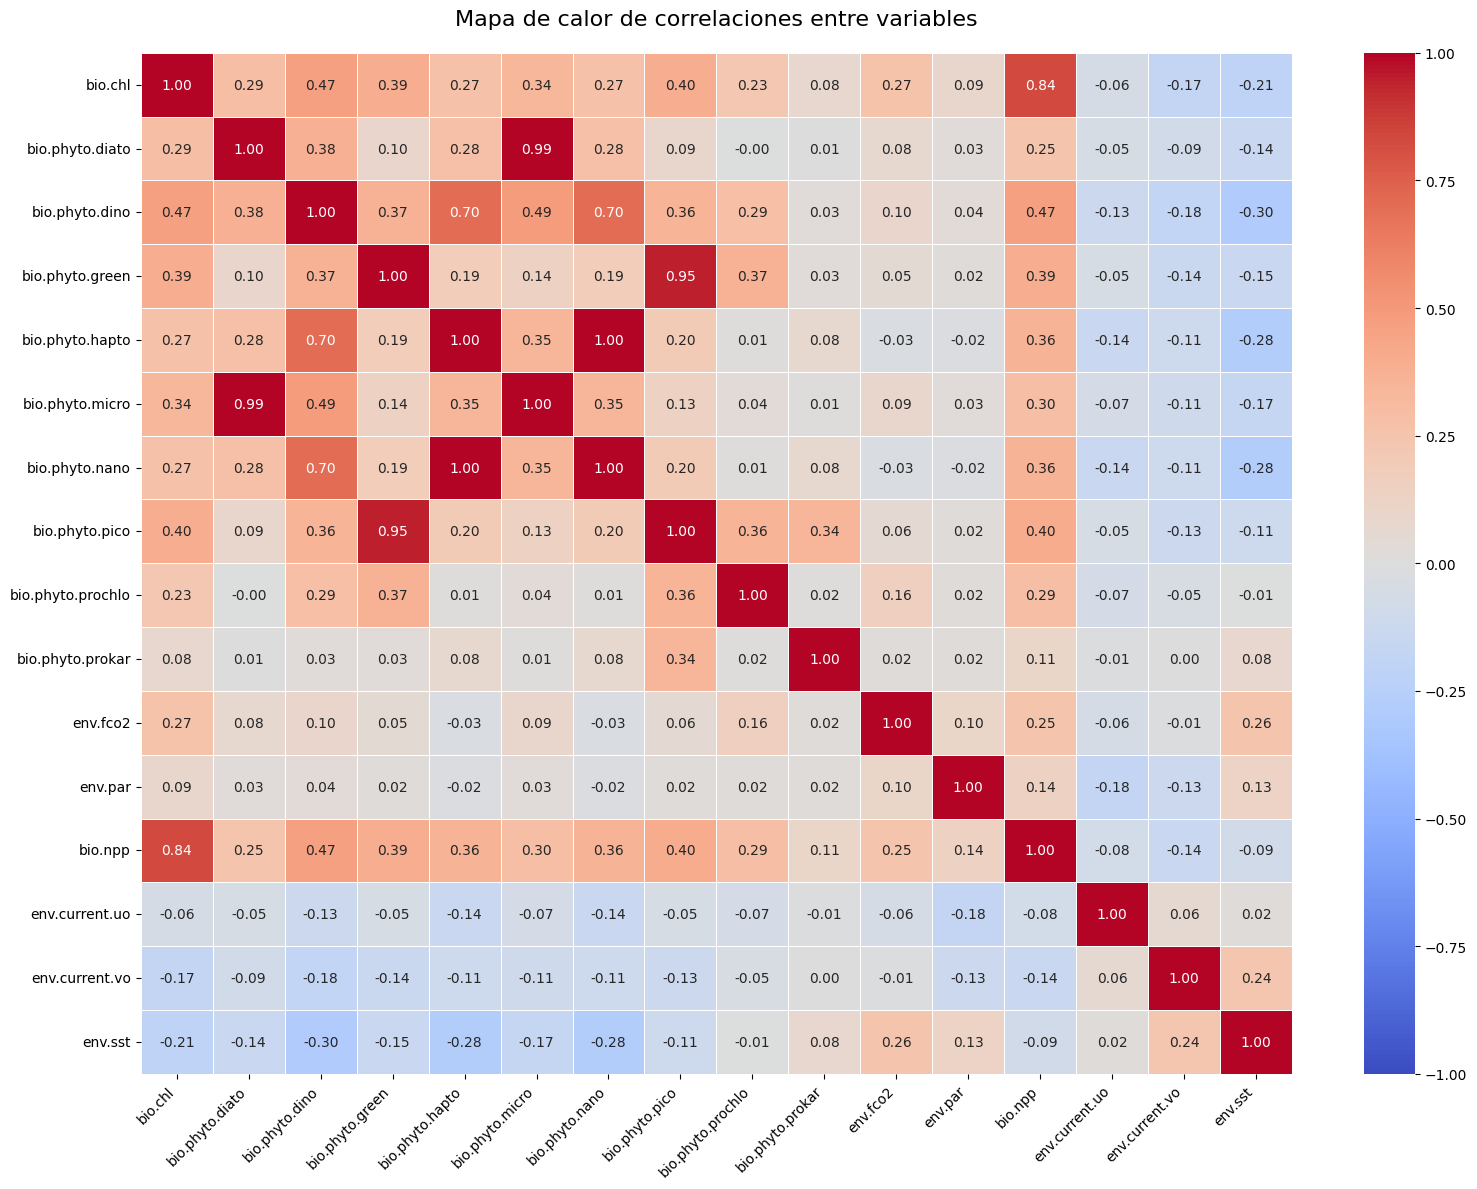

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Cargar los datos (ajusta el path según sea necesario)
df = pd.read_csv(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\measurements.tsv", sep="\t")

# 2. Seleccionar solo las columnas numéricas para la correlación
# Excluyendo columnas no numéricas o que no queremos correlacionar
columns_to_correlate = ['bio.chl', 'bio.phyto.diato', 'bio.phyto.dino', 'bio.phyto.green', 'bio.phyto.hapto', 'bio.phyto.micro', 
                       'bio.phyto.nano', 'bio.phyto.pico', 'bio.phyto.prochlo', 'bio.phyto.prokar', 'env.fco2',
                       'env.par', 'bio.npp', 'env.current.uo', 'env.current.vo', 'env.sst']

# 3. Calcular la matriz de correlación
corr_matrix = df[columns_to_correlate].corr()

# 4. Crear el mapa de calor
plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(corr_matrix, 
                      annot=True, 
                      fmt=".2f", 
                      cmap='coolwarm',
                      center=0,
                      vmin=-1, 
                      vmax=1,
                      linewidths=0.5,
                      annot_kws={"size": 10})

# 5. Mejorar la visualización
plt.title('Mapa de calor de correlaciones entre variables', pad=20, fontsize=16)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

# 6. Mostrar el gráfico
plt.tight_layout()
plt.show()

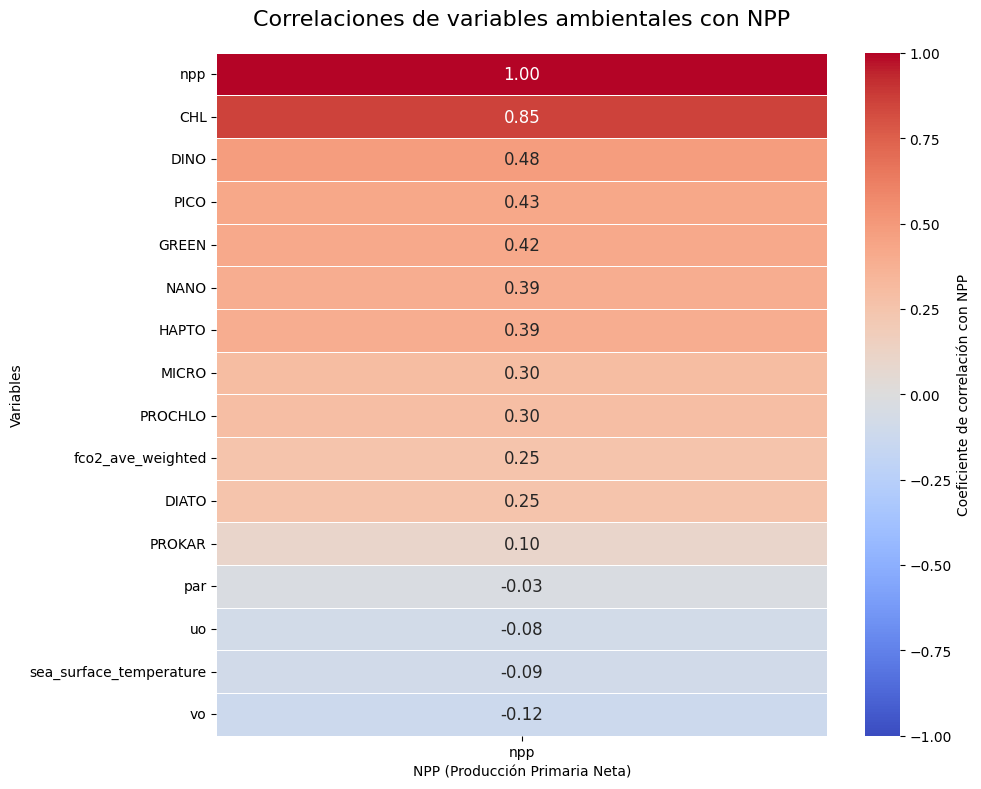

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar los datos
df = pd.read_csv('final_combined_with_gridid.csv')

# Seleccionar variables (NPP como última para destacarla)
variables = ['CHL', 'DIATO', 'DINO', 'GREEN', 'HAPTO', 'MICRO', 'NANO', 
             'PICO', 'PROCHLO', 'PROKAR', 'fco2_ave_weighted', 'par', 
             'uo', 'vo', 'sea_surface_temperature', 'npp']

# Calcular matriz de correlación
corr_matrix = df[variables].corr()

# Extraer solo las correlaciones con NPP
npp_correlations = corr_matrix[['npp']].sort_values(by='npp', ascending=False)

# Crear el heatmap específico para NPP
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(npp_correlations, 
                      annot=True, 
                      fmt=".2f", 
                      cmap='coolwarm',
                      center=0,
                      vmin=-1, 
                      vmax=1,
                      linewidths=0.5,
                      cbar_kws={'label': 'Coeficiente de correlación con NPP'},
                      annot_kws={"size": 12})

# Personalización
plt.title('Correlaciones de variables ambientales con NPP', pad=20, fontsize=16)
plt.ylabel('Variables')
plt.xlabel('NPP (Producción Primaria Neta)')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

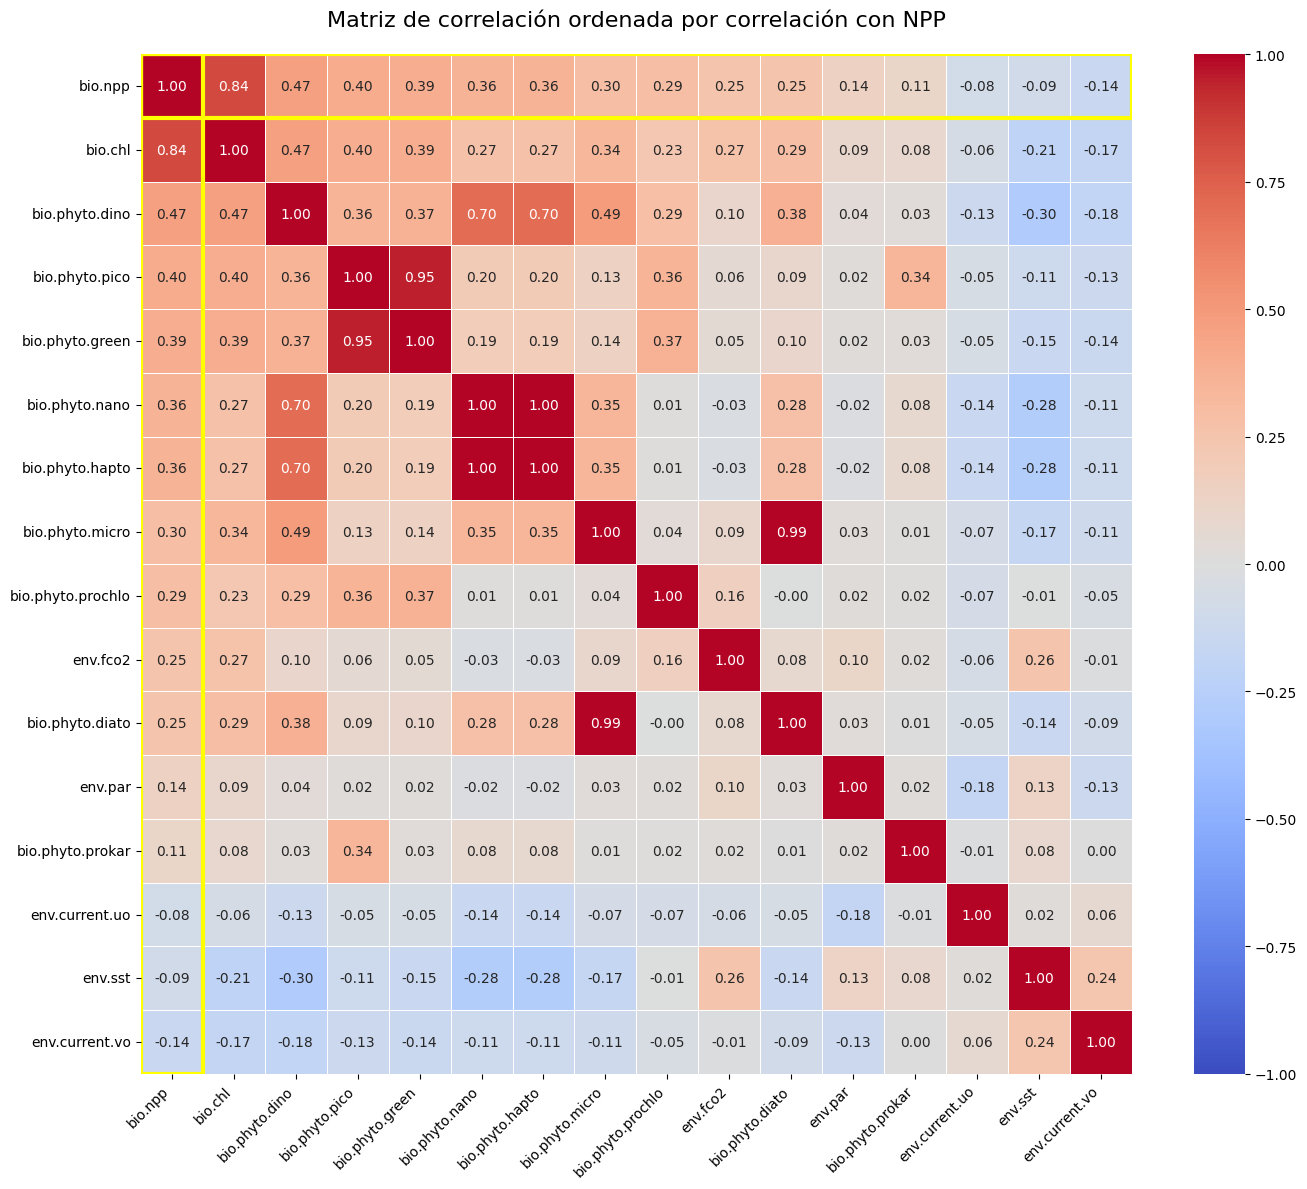

In [4]:
# Ordenar todas las variables según su correlación con NPP
sorted_vars = corr_matrix['bio.npp'].sort_values(ascending=False).index
sorted_corr = corr_matrix.loc[sorted_vars, sorted_vars]

# Crear heatmap completo pero ordenado por NPP
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(sorted_corr, 
                      annot=True, 
                      fmt=".2f", 
                      cmap='coolwarm',
                      center=0,
                      vmin=-1, 
                      vmax=1,
                      linewidths=0.5,
                      annot_kws={"size": 10})

# Destacar la fila/columna de NPP
heatmap.add_patch(plt.Rectangle((0, sorted_vars.get_loc('bio.npp')), 
                           len(sorted_vars), 1, 
                           fill=False, edgecolor='yellow', lw=3))
heatmap.add_patch(plt.Rectangle((sorted_vars.get_loc('bio.npp'), 0), 
                           1, len(sorted_vars), 
                           fill=False, edgecolor='yellow', lw=3))

# Personalización
plt.title('Matriz de correlación ordenada por correlación con NPP', pad=20, fontsize=16)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.tight_layout()
plt.show()

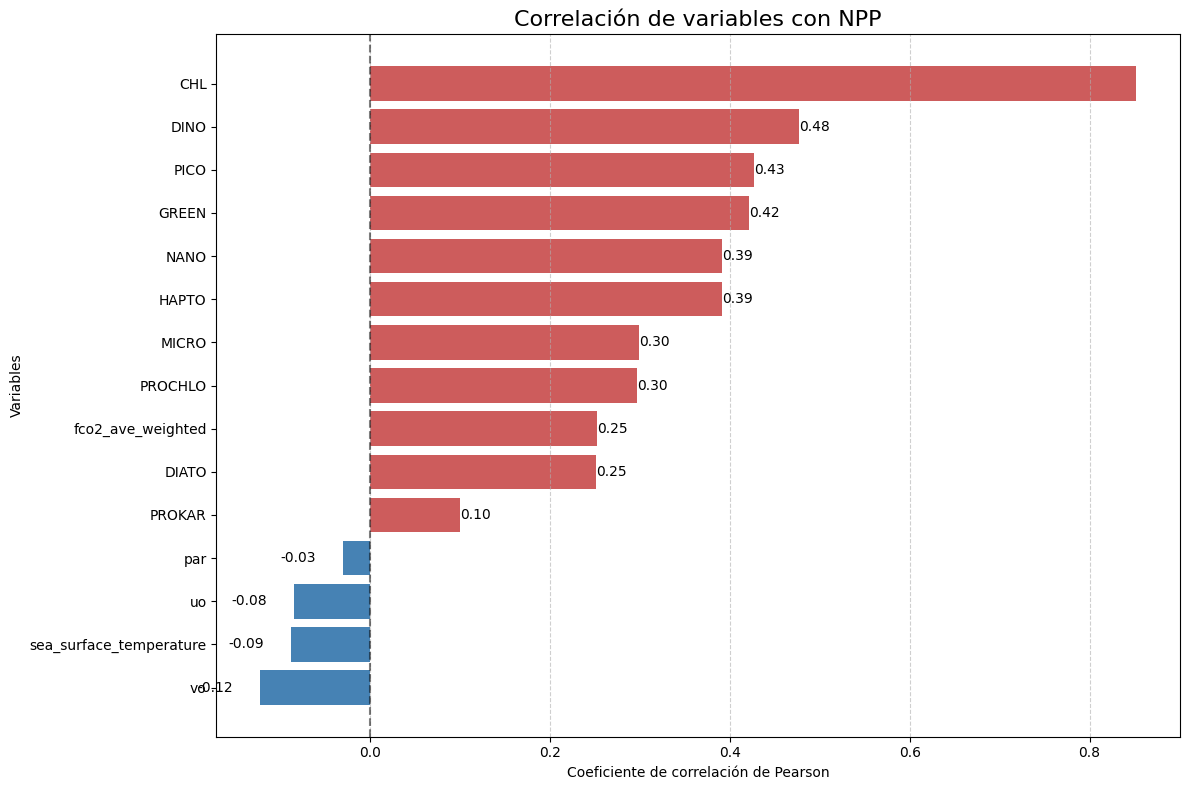

In [7]:
# Crear gráfico de barras de las correlaciones con NPP
npp_corrs = corr_matrix['npp'].drop('npp').sort_values()

plt.figure(figsize=(12, 8))
bars = plt.barh(npp_corrs.index, npp_corrs.values, 
                color=np.where(npp_corrs > 0, 'indianred', 'steelblue'))

# Añadir etiquetas de valor
for bar in bars:
    width = bar.get_width()
    plt.text(width if width >0 else width - 0.03, 
             bar.get_y() + bar.get_height()/2, 
             f'{width:.2f}', 
             va='center', ha='left' if width>0 else 'right',
             color='white' if abs(width)>0.5 else 'black')

# Línea vertical en cero y personalización
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
plt.title('Correlación de variables con NPP', fontsize=16)
plt.xlabel('Coeficiente de correlación de Pearson')
plt.ylabel('Variables')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Refactorización

In [3]:
import pandas as pd

# Cargar CSV original
df = pd.read_csv(r"C:\Users\imano\Desktop\4o CARRERA\TFG\project\data\dataset_region.csv")

# Renombrar columnas
df_out = pd.DataFrame()
df_out["ts"] = df["time"]
df_out["tile"] = df["grid_id"]
df_out["env_sst"] = df["sea_surface_temperature"]
df_out["env_par"] = df["par"]
df_out["env_fco2"] = df["fco2_ave_weighted"]
df_out["env_current_uo"] = df["uo"]
df_out["env_current_vo"] = df["vo"]
df_out["bio_chl"] = df["CHL"]
df_out["bio_phyto_diato"] = df["DIATO"]
df_out["bio_phyto_dino"] = df["DINO"]
df_out["bio_phyto_green"] = df["GREEN"]
df_out["bio_phyto_hapto"] = df["HAPTO"]
df_out["bio_phyto_micro"] = df["MICRO"]
df_out["bio_phyto_nano"] = df["NANO"]
df_out["bio_phyto_pico"] = df["PICO"]
df_out["bio_phyto_prochlo"] = df["PROCHLO"]
df_out["bio_phyto_prokar"] = df["PROKAR"]
df_out["bio_npp"] = df["npp"]

# Exportar como TSV
df_out.to_csv(r"C:\Users\imano\Desktop\4o CARRERA\TFG\project\data\dataset_region.tsv", sep="\t", index=False)

In [1]:
print("Archivo 'measurements.tsv' creado con éxito.")

Archivo 'measurements.tsv' creado con éxito.


In [10]:
import pandas as pd

def index_to_letters(i):
    """Convierte un índice entero en letras estilo Excel: 0 → A, 1 → B, ..., 25 → Z, 26 → AA, etc."""
    result = ""
    i += 1  # Excel-style index starts at 1
    while i > 0:
        i -= 1
        result = chr(65 + (i % 26)) + result
        i //= 26
    return result

# Cargar CSV con la información de las celdas (con grid_id y coordenadas latitud-longitud)
df = pd.read_csv(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\npp_interpolated.csv")

# Obtener los valores únicos de latitudes y longitudes ordenados
lats = sorted(df["latitude"].unique(), reverse=True)  # Invertimos el orden de las latitudes
lons = sorted(df["longitude"].unique())

# Verificar dimensiones esperadas
assert len(lats) == 480, f"Se esperaban 480 latitudes, pero hay {len(lats)}"
assert len(lons) == 480, f"Se esperaban 480 longitudes, pero hay {len(lons)}"

# Generar los ID de la grilla en formato A,1; Z,480; AA,1; etc.
rows = []
for i, lat in enumerate(lats):
    row_letter = index_to_letters(i)
    for j, lon in enumerate(lons):
        col_number = j + 1
        tile = f"{row_letter}{col_number}"
        rows.append({
            "tile": tile,
            "lat": lat,
            "lon": lon
        })

# Crear DataFrame con los resultados
grid_df = pd.DataFrame(rows)

# Exportar el resultado como archivo TSV
grid_df.to_csv(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\grid.tsv", sep="\t", index=False, header=False)

In [11]:
import pandas as pd

# Leer el archivo actual
df = pd.read_csv(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\grid.tsv", sep='\t', header=None, names=['tile', 'lat', 'lon'])

# Ordenar primero por latitud (de menor a mayor) y luego por longitud (de menor a mayor)
df_sorted = df.sort_values(by=['lon', 'lat'])

# Renumerar los tiles como A1, A2, A3...
df_sorted['tile'] = ['A' + str(i+1) for i in range(len(df_sorted))]

# Guardar el nuevo archivo
df_sorted.to_csv(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\grid.tsv", sep='\t', index=False, header=False)

### Otros datos

In [2]:
import xarray as xr
import numpy as np

# Cargar el archivo
ds = xr.open_dataset(r"C:\Users\imano\Desktop\CAFE_NPP_8D_25KM_1998_2022.nc")

# Renombrar dimensiones
ds = ds.rename({'lon': 'longitude', 'lat': 'latitude'})

# Seleccionar el área deseada
subset = ds.sel(
    longitude=slice(-27, -7),
    latitude=slice(13, 33)  # ojo: latitudes decrecientes
)

# # Crear nuevas coordenadas interpoladas (480x480)
new_lons = np.linspace(-27, -7, 480)
new_lats = np.linspace(33, 13, 480)

# Reinterpolar los datos
interp = subset.interp(
    longitude=new_lons,
    latitude=new_lats
)

print(subset.dims)

# Guardar el nuevo archivo NetCDF
interp.to_netcdf(r"C:\Users\imano\Desktop\CAFE_NPP_subset_480x480.nc")

FrozenMappingWarningOnValuesAccess({'time': 1150, 'latitude': 80, 'longitude': 80})


In [3]:
import xarray as xr
import numpy as np
import pandas as pd

# Cargar el dataset original
ds = xr.open_dataset(r"C:\Users\imano\Desktop\CAFE_NPP_subset_480x480.nc")

# Recortar fechas desde 1998-08-01
ds = ds.sel(time=ds.time >= np.datetime64('2002-08-01'))

# Convertir la coordenada 'time' a Period (mes)
ds['time'] = pd.to_datetime(ds['time'].values).to_period('M')

# Agrupar por el nuevo período mensual y calcular el promedio
monthly_mean = ds.groupby('time').mean(dim='time')

# Crear nueva coordenada time con el primer día de cada mes
new_time = pd.date_range(start="2002-08-01", periods=monthly_mean.sizes['time'], freq="MS")

# Reemplazar la coordenada de tiempo
monthly_mean = monthly_mean.rename({'time': 'time'})
monthly_mean = monthly_mean.assign_coords(time=new_time)

# Guardar como nuevo NetCDF
monthly_mean.to_netcdf(r"C:\Users\imano\Desktop\CAFE_NPP_2002_to_2022.nc")

print("✅ Dataset mensual creado correctamente.")

✅ Dataset mensual creado correctamente.


In [4]:
import xarray as xr
import numpy as np
import pandas as pd

# Abrir el dataset original
ds = xr.open_dataset(r"C:\Users\imano\Desktop\CAFE_NPP_2002_to_2022.nc")

# Recortar fechas desde 1998-08-01
ds = ds.sel(time=ds.time >= np.datetime64('1998-08-01'))

# Convertir la coordenada 'time' a un DatetimeIndex
time_values = pd.to_datetime(ds['time'].values)

# Crear una lista con los primeros días de cada mes
first_of_month = pd.to_datetime([f'{t.year}-{t.month:02d}-01' for t in time_values])

# Ahora, tomar solo los primeros días únicos (sin repeticiones)
unique_first_of_month = pd.to_datetime(np.unique(first_of_month))

# Agrupar por mes y calcular el promedio de las variables
monthly_mean = ds.resample(time='1M').mean()

# Asignar los primeros días de mes como nueva coordenada 'time'
monthly_mean = monthly_mean.assign_coords(time=unique_first_of_month[:monthly_mean.sizes['time']])

# Guardar el dataset como nuevo archivo NetCDF
monthly_mean.to_netcdf(r"C:\Users\imano\Desktop\CAFE_NPP_monthly_averaged_fixed_time.nc")

print("✅ Dataset mensual con timestamps corregidos creado correctamente.")


c:\Users\imano\AppData\Local\Programs\Python\Python313\Lib\site-packages\xarray\groupers.py:487: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


✅ Dataset mensual con timestamps corregidos creado correctamente.


In [ ]:
import xarray as xr
import numpy as np
import pandas as pd

# Abrir el dataset original
ds = xr.open_dataset(r"C:\Users\imano\Desktop\CAFE_NPP_monthly_averaged_fixed_time.nc")

ds.to_dataframe().to_csv(r"C:\Users\imano\Desktop\CAFE_NPP_monthly_averaged_fixed_time.csv")

In [ ]:
import pandas as pd
import numpy as np

# Función para convertir número a letras (ej: 1 -> 'A', 27 -> 'AA')
def number_to_letters(n):
    letters = []
    while n > 0:
        n -= 1
        letters.append(chr(ord('A') + (n % 26)))
        n = n // 26
    return ''.join(reversed(letters))

# Cargar CSV original
df = pd.read_csv(r"C:\Users\imano\Desktop\CAFE_NPP_monthly_averaged_fixed_time.csv")

# Asumimos que el orden de filas en el CSV ya es línea por línea (por tiempo), y para cada tiempo hay 480x480 valores
num_cols = 480
num_rows = 480

# Generar nombres de tile (A1, A2, ..., A480, B1, ..., RL480)
tile_names = [f"{number_to_letters(row+1)}{col+1}" for row in range(num_rows) for col in range(num_cols)]

# Asegurar que el DataFrame tiene el número esperado de filas múltiplo de 480*480
assert len(df) % len(tile_names) == 0, "El número de filas no es múltiplo de 480x480"

# Repetir los nombres de tile por cada bloque temporal
repeats = len(df) // len(tile_names)
tile_column = tile_names * repeats

# Crear columnas finales
df["tile"] = tile_column
df.rename(columns={"time": "ts", "VGPM": "bio.npp.estimations"}, inplace=True)

# Nos quedamos solo con las columnas necesarias
df_final = df[["ts", "bio.npp.estimations", "tile"]]

# Guardar como TSV
output_path = r"C:\Users\imano\Desktop\CAFE_NPP_8D_25KM_1998_2022.nc\VGPM_NPP_tidy.tsv"
df_final.to_csv(output_path, sep='\t', index=False)

### Modificación del NetCDF

In [8]:
import xarray as xr

# Abrimos el dataset
ds = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\Datos\final_combined.nc")

# Creamos una nueva variable 'par' con los datos invertidos en latitud (sin invertir la coordenada)
ds['par'].data[:] = ds['par'].data[:, ::-1, :]

# Guardamos el resultado
ds.to_netcdf("final_combined.nc")

In [ ]:
import xarray as xr
import numpy as np

# Abrir el NetCDF
ds = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\final_combined_with_gridid_v3.nc")

# Convertir tiempos a formato datetime (por si acaso no lo está)
ds['time'] = xr.cftime_range(start="2002-08-01", periods=ds.dims['time'], freq='MS')

# Seleccionar CHL en enero de 2021
chl_jan_2021 = ds['CHL'].sel(time='2021-01')

# Crear la máscara isOcean: True donde hay dato, False donde hay NaN
is_ocean = ~np.isnan(chl_jan_2021)

# Añadir al dataset original como nueva variable
ds['isOcean'] = is_ocean
ds['isOcean'].attrs['long_name'] = 'Ocean Mask based on CHL presence on Jan 2021'
ds['isOcean'].attrs['description'] = 'True if ocean (CHL data exists), False otherwise'

# (Opcional) Guardar a nuevo NetCDF
ds.to_netcdf(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\final_with_isOcean.nc")

C:\Users\imano\AppData\Local\Temp\ipykernel_53264\2801984929.py:8: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ds['time'] = xr.cftime_range(start="2002-08-01", periods=ds.dims['time'], freq='MS')


In [6]:
import xarray as xr
import numpy as np

# Ruta al archivo NetCDF
file_path = r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\final_combined_with_gridid_v3.nc"

# Abrimos el dataset original
ds = xr.open_dataset(file_path)

# Fecha objetivo
target_date = np.datetime64('2021-01-01')

# Índice del tiempo más cercano
time_index = np.argmin(np.abs(ds['time'].values - target_date))

# Extraemos CHL en ese tiempo
chl_slice = ds['CHL'].isel(time=time_index)

# Creamos la máscara binaria
is_ocean = xr.where(np.isnan(chl_slice), 0, 1)
is_ocean.name = "is_ocean"
is_ocean.attrs['description'] = "Máscara binaria: 1=océano, 0=tierra"
is_ocean.attrs['source'] = "Calculada a partir de CHL"

# Añadimos la variable al dataset
ds['is_ocean'] = is_ocean

# Guardamos todo el dataset incluyendo la nueva variable
output_path = r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\final_with_isOcean.nc"
ds.to_netcdf(output_path)

print(f"Dataset guardado con is_ocean en: {output_path}")


Dataset guardado con is_ocean en: C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\final_with_isOcean.nc


In [ ]:
import xarray as xr
import numpy as np
from scipy.interpolate import griddata
import tqdm

# Carga del archivo NetCDF
ds = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\final_with_isOcean.nc")

# Extraemos las variables
npp = ds["npp"]
is_ocean = ds["is_ocean"]

# Convertimos la máscara a booleano
ocean_mask = is_ocean == 1

# Copia del array para modificar
npp_interp = npp.copy()

# Iteramos sobre el tiempo
for t in tqdm.tqdm(range(npp.shape[0]), desc="Interpolando"):
    # Selecciona la capa npp en el instante t. .isel(time=t) accede a ese índice temporal, y .values lo convierte a un array NumPy de 2D (latitud x longitud).
    npp_t = npp.isel(time=t).values
    # Obtiene la máscara de océano (True donde is_ocean == 1, False donde no) como un array NumPy. Esta máscara no cambia en el tiempo.
    mask_t = ocean_mask.values

    # Crea dos matrices (latitudes, longitudes) que representan la rejilla completa de coordenadas. Usamos indexing="ij" para mantener la correspondencia (lat, lon).
    latitudes, longitudes = np.meshgrid(ds.latitude.values, ds.longitude.values, indexing="ij")

    # Crea una máscara donde: mask_t (es océano) es True y npp_t NO es NaN. O sea, son los puntos donde hay datos de npp válidos en el océano.
    valid_mask = mask_t & ~np.isnan(npp_t)
    # Si no hay ningún punto válido en ese tiempo (es todo NaN o todo tierra), salta a la siguiente iteración. Así evita errores de interpolación.
    if not np.any(valid_mask):
        continue  # si no hay puntos válidos, saltamos

    # Combina las coordenadas lat/lon solo en los puntos válidos en una matriz 2D de forma (n_puntos, 2) para usarlas como puntos conocidos en la interpolación.
    points = np.column_stack((latitudes[valid_mask], longitudes[valid_mask]))
    # Toma los valores de npp correspondientes a esos puntos conocidos.
    values = npp_t[valid_mask]

    # Crea otra máscara donde: es océano (mask_t) y el valor de npp_t es NaN. Son los puntos que necesitamos rellenar.
    interp_mask = mask_t & np.isnan(npp_t)
    # Extrae las coordenadas de los puntos donde vamos a interpolar.
    interp_points = np.column_stack((latitudes[interp_mask], longitudes[interp_mask]))

    # Usa scipy.interpolate.griddata para interpolar los valores en los puntos donde falta información usando los datos conocidos. El método "linear" hace interpolación lineal.
    interpolated_values = griddata(points, values, interp_points, method="linear")

    # Rellena los valores NaN con los valores interpolados en el array npp_t.
    npp_t[interp_mask] = interpolated_values

    # Guarda esa nueva capa (ya sin NaNs en el océano) en el dataset de salida.
    npp_interp[t, :, :] = npp_t

# Sustituimos la variable npp original
ds["npp"] = npp_interp

# Guardamos en nuevo NetCDF
ds.to_netcdf(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\final_with_isOcean_filled.nc")

Interpolando: 100%|██████████| 257/257 [19:39<00:00,  4.59s/it]


In [5]:
# ESTE ES EL CÓDIGO NUEVO FINAL PARA INTERPOLAR NPP
import xarray as xr
import numpy as np
from scipy.interpolate import RBFInterpolator

# Rutas de archivos
# FILE = r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\final_with_isOcean.nc"
FILE = r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\dataset_rbf_interpolation2.nc"
OUTPUT = r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\dataset_rbf_interpolation3.nc"

# Cargar dataset
ds = xr.open_dataset(FILE)

# Extraer datos
data = ds['vo'].values
is_ocean = ds['is_ocean'].values.astype(bool)
lat = ds['latitude'].values
lon = ds['longitude'].values

# Crear mallas 2D de coordenadas
lon2d, lat2d = np.meshgrid(lon, lat)

# Copia para almacenar datos interpolados
filled_data = data.copy()

# Parámetros de interpolación
MAX_POINTS = 5000  # Máximo de puntos válidos a usar
SMOOTHING = 1e-2   # Parámetro de suavizado

# Iterar sobre cada paso temporal
for t in range(data.shape[0]):
    print(f"🕒 Procesando tiempo {t+1}/{data.shape[0]}")

    slice_data = data[t]
    valid_mask = is_ocean & ~np.isnan(slice_data)
    missing_mask = is_ocean & np.isnan(slice_data)

    if np.sum(valid_mask) < 10:
        print("  ⚠️ Muy pocos datos válidos. Se omite este paso temporal.")
        continue

    # Coordenadas y valores válidos
    valid_points = np.column_stack((lon2d[valid_mask], lat2d[valid_mask]))
    valid_values = slice_data[valid_mask]

    # Puntos faltantes
    target_points = np.column_stack((lon2d[missing_mask], lat2d[missing_mask]))

    # Submuestreo si hay demasiados puntos válidos
    if len(valid_points) > MAX_POINTS:
        indices = np.random.choice(len(valid_points), MAX_POINTS, replace=False)
        sample_points = valid_points[indices]
        sample_values = valid_values[indices]
    else:
        sample_points = valid_points
        sample_values = valid_values

    # Crear interpolador RBF
    try:
        rbf = RBFInterpolator(sample_points, sample_values, kernel='thin_plate_spline', smoothing=SMOOTHING)
        interp_values = rbf(target_points)
    except Exception as e:
        print(f"  ⚠️ Error en la interpolación RBF: {e}")
        continue

    # Asignar valores interpolados al slice
    filled_slice = slice_data.copy()
    filled_slice[missing_mask] = interp_values

    # Forzar valores en tierra a NaN
    filled_slice[~is_ocean] = np.nan

    # Almacenar el slice interpolado
    filled_data[t] = filled_slice

# Reemplazar los datos en el dataset original
ds['vo'].values = filled_data

# Guardar el dataset interpolado
ds.to_netcdf(OUTPUT)
print(f"\n✅ Interpolación finalizada. Archivo guardado en: {OUTPUT}")

🕒 Procesando tiempo 1/257
🕒 Procesando tiempo 2/257
🕒 Procesando tiempo 3/257
🕒 Procesando tiempo 4/257
🕒 Procesando tiempo 5/257
🕒 Procesando tiempo 6/257
🕒 Procesando tiempo 7/257
🕒 Procesando tiempo 8/257
🕒 Procesando tiempo 9/257
🕒 Procesando tiempo 10/257
🕒 Procesando tiempo 11/257
🕒 Procesando tiempo 12/257
🕒 Procesando tiempo 13/257
🕒 Procesando tiempo 14/257
🕒 Procesando tiempo 15/257
🕒 Procesando tiempo 16/257
🕒 Procesando tiempo 17/257
🕒 Procesando tiempo 18/257
🕒 Procesando tiempo 19/257
🕒 Procesando tiempo 20/257
🕒 Procesando tiempo 21/257
🕒 Procesando tiempo 22/257
🕒 Procesando tiempo 23/257
🕒 Procesando tiempo 24/257
🕒 Procesando tiempo 25/257
🕒 Procesando tiempo 26/257
🕒 Procesando tiempo 27/257
🕒 Procesando tiempo 28/257
🕒 Procesando tiempo 29/257
🕒 Procesando tiempo 30/257
🕒 Procesando tiempo 31/257
🕒 Procesando tiempo 32/257
🕒 Procesando tiempo 33/257
🕒 Procesando tiempo 34/257
🕒 Procesando tiempo 35/257
🕒 Procesando tiempo 36/257
🕒 Procesando tiempo 37/257
🕒 Procesan

In [1]:
# ESTE ES EL CÓDIGO ANTIGUOOOOOO FINAL PARA INTERPOLAR NPP

import xarray as xr
import numpy as np
from scipy.interpolate import griddata

# Carga del dataset
ds = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\final_with_isOcean.nc")

# Variables necesarias
npp = ds["npp"].values
is_ocean = ds["is_ocean"].values
latitudes = ds["latitude"].values
longitudes = ds["longitude"].values
time = ds["time"].values

# Coordenadas en forma de malla
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

# Recorre cada instante temporal
for t in range(npp.shape[0]):
    npp_slice = npp[t, :, :]
    ocean_mask = is_ocean == 1
    nan_mask = np.isnan(npp_slice)
    mask = ocean_mask & nan_mask

    if np.any(mask):
        # Puntos válidos para interpolar
        valid_mask = ~np.isnan(npp_slice) & ocean_mask
        if not np.any(valid_mask):
            continue  # No hay datos válidos ese día

        # Coordenadas de los puntos con datos válidos
        points = np.column_stack((lat_grid[valid_mask], lon_grid[valid_mask]))
        values = npp_slice[valid_mask]

        # Coordenadas de los puntos a interpolar
        interp_points = np.column_stack((lat_grid[mask], lon_grid[mask]))

        # Interpolación lineal
        interpolated_values = griddata(points, values, interp_points, method="linear")

        # Interpolación nearest para los que fallaron con linear
        still_nan = np.isnan(interpolated_values)
        if np.any(still_nan):
            interpolated_values_nearest = griddata(points, values, interp_points[still_nan], method="nearest")
            interpolated_values[still_nan] = interpolated_values_nearest

        # Asigna los valores interpolados al array original
        npp_slice[mask] = interpolated_values
        npp[t, :, :] = npp_slice

# Crea nuevo dataset y guarda
ds["npp"][:] = npp
ds.to_netcdf(r"C:\Users\imano\Desktop\4o CARRERA\npp_interpolated.nc")

In [1]:
import xarray as xr
DS = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\dataset_rbf_interpolation3.nc")
DS.to_dataframe().to_csv(r"C:\Users\imano\Desktop\4o CARRERA\datos.csv")

In [2]:
import pandas as pd

# Cargar CSV original
df = pd.read_csv(r"C:\Users\imano\Desktop\4o CARRERA\datos.csv")

# Filtrar solo las filas donde is_ocean == 1
df = df[df['is_ocean'] == 1]

# Crear DataFrame de salida con las columnas renombradas
df_out = pd.DataFrame()
df_out["ts"] = df["time"]
df_out["tile"] = df["grid_id"]
df_out["env.sst"] = df["sea_surface_temperature"]
df_out["env.par"] = df["par"]
df_out["env.fco2"] = df["fco2_ave_weighted"]
df_out["env.current.uo"] = df["uo"]
df_out["env.current.vo"] = df["vo"]
df_out["bio.chl"] = df["CHL"]
df_out["bio.phyto.diato"] = df["DIATO"]
df_out["bio.phyto.dino"] = df["DINO"]
df_out["bio.phyto.green"] = df["GREEN"]
df_out["bio.phyto.hapto"] = df["HAPTO"]
df_out["bio.phyto.micro"] = df["MICRO"]
df_out["bio.phyto.nano"] = df["NANO"]
df_out["bio.phyto.pico"] = df["PICO"]
df_out["bio.phyto.prochlo"] = df["PROCHLO"]
df_out["bio.phyto.prokar"] = df["PROKAR"]
df_out["bio.npp"] = df["npp"]

# Exportar como TSV
df_out.to_csv(r"C:\Users\imano\Desktop\4o CARRERA\measurements.tsv", sep="\t", index=False)

In [ ]:
import pandas as pd

# Cargar CSV original
df = pd.read_csv(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\npp_interpolated.csv")

# Filtrar solo las filas donde 'time' es '2002-08-01'
df_filtered = df[df["time"] == "2002-08-01"]

# Renombrar columnas (solo para las filas filtradas)
df_out = pd.DataFrame()
df_out["ts"] = df_filtered["time"]
df_out["tile"] = df_filtered["grid_id"]
df_out["env.sst"] = df_filtered["sea_surface_temperature"]
df_out["env.par"] = df_filtered["par"]
df_out["env.fco2"] = df_filtered["fco2_ave_weighted"]
df_out["env.current.uo"] = df_filtered["uo"]
df_out["env.current.vo"] = df_filtered["vo"]
df_out["bio.chl"] = df_filtered["CHL"]
df_out["bio.phyto.diato"] = df_filtered["DIATO"]
df_out["bio.phyto.dino"] = df_filtered["DINO"]
df_out["bio.phyto.green"] = df_filtered["GREEN"]
df_out["bio.phyto.hapto"] = df_filtered["HAPTO"]
df_out["bio.phyto.micro"] = df_filtered["MICRO"]
df_out["bio.phyto.nano"] = df_filtered["NANO"]
df_out["bio.phyto.pico"] = df_filtered["PICO"]
df_out["bio.phyto.prochlo"] = df_filtered["PROCHLO"]
df_out["bio.phyto.prokar"] = df_filtered["PROKAR"]
df_out["bio.npp"] = df_filtered["npp"]
df_out["isOcean"] = df_filtered["is_ocean"]

# Exportar como TSV
df_out.to_csv(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\measurements_v1.tsv", sep="\t", index=False)

In [ ]:
from scipy.ndimage import gaussian_filter
import xarray as xr
import numpy as np

# Cargar el dataset original
ds = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\npp_interpolated.nc")

# Aplicar filtro gaussiano a los datos de fCO2
fco2_smoothed = gaussian_filter(ds['fco2_ave_weighted'], sigma=1.5)

# Crear un nuevo dataset xarray con la variable suavizada
smoothed_ds = xr.Dataset(
    {
        'fco2_smoothed': (('time', 'latitude', 'longitude'), fco2_smoothed)
    },
    coords={
        'time': ds.time,
        'latitude': ds.latitude,
        'longitude': ds.longitude
    }
)

# Copiar los atributos de la variable original
smoothed_ds['fco2_smoothed'].attrs = ds['fco2_ave_weighted'].attrs
smoothed_ds['fco2_smoothed'].attrs['description'] = 'Smoothed version of fco2_ave_weighted using Gaussian filter (sigma=1.5)'

# Guardar el nuevo dataset como NetCDF
output_path = r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\fco2_smoothed.nc"
smoothed_ds.to_netcdf(output_path)

print(f"Archivo guardado en: {output_path}")

Archivo guardado en: C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\fco2_smoothed.nc


### Datos in situ PBMax

In [11]:
import pandas as pd

# Cargar el archivo .tab
df = pd.read_csv(r"C:\Users\imano\Desktop\Bouman_correct_final.tab", sep=r'\s+', engine='python')

# Guardarlo como .csv
df.to_csv(r"C:\Users\imano\Desktop\Bouman_correct_final.csv", index=False)

In [ ]:
import pandas as pd
import numpy as np
import xarray as xr

# Cargar CSV
df = pd.read_csv(r"C:\Users\imano\Desktop\Bouman_correct_final.csv")

# Convertir DateTime a datetime real de pandas
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Crear listas únicas
time = np.sort(df['DateTime'].unique())
longitudes = np.sort(df['Longitude'].unique())
latitudes = np.sort(df['Latitude'].unique())
depths = np.sort(df['DepthWater'].unique())

# Crear array vacío para PBmax
PBmax_array = np.full((len(times), len(depths), len(latitudes), len(longitudes)), np.nan)

# Rellenar el array
for _, row in df.iterrows():
    time_idx = np.where(times == np.datetime64(row['DateTime']))[0][0]
    lon_idx = np.where(longitudes == row['Longitude'])[0][0]
    lat_idx = np.where(latitudes == row['Latitude'])[0][0]
    depth_idx = np.where(depths == row['DepthWater'])[0][0]
    PBmax_array[time_idx, depth_idx, lat_idx, lon_idx] = row['PBmax']

# Crear Dataset de xarray
ds = xr.Dataset(
    {
        "PBmax": (["time", "depth", "latitude", "longitude"], PBmax_array)
    },
    coords={
        "time": ("time", times, {
            "units": "days since 1997-11-20",
            "calendar": "proleptic_gregorian",
            "standard_name": "time"
        }),
        "depth": ("depth", depths, {
            "units": "meters",
            "positive": "down",
            "standard_name": "depth"
        }),
        "latitude": ("latitude", latitudes, {
            "units": "degrees_north",
            "standard_name": "latitude"
        }),
        "longitude": ("longitude", longitudes, {
            "units": "degrees_east",
            "standard_name": "longitude"
        })
    }
)

# Atributos de la variable PBmax
ds["PBmax"].attrs["long_name"] = "Maximum PB value"
ds["PBmax"].attrs["units"] = "unknown"  # Pon aquí la unidad correcta si la sabes

# Opcional: atributos globales
ds.attrs["title"] = "PBmax in situ measurements"
ds.attrs["institution"] = "Your Institution"
ds.attrs["source"] = "In situ measurements"
ds.attrs["history"] = "Created " + pd.Timestamp.now().isoformat()

# Guardar como NetCDF
ds.to_netcdf(r"C:\Users\imano\Desktop\Bouman_correct_final_with_depth.nc")


In [ ]:
import pandas as pd
import xarray as xr

# Paso 1: Cargar el archivo CSV
df = pd.read_csv(r"C:\Users\imano\Desktop\Bouman_correct_final.csv")

# Paso 2: Convertir la columna DateTime a tipo datetime
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Paso 3: Eliminar duplicados y promediar PBmax
df_cleaned = df.groupby(['DateTime', 'DepthWater', 'Latitude', 'Longitude'], as_index=False)['PBmax'].mean()

# Paso 4: Convertir el DataFrame limpio a xarray
ds = df_cleaned.set_index(['DateTime', 'DepthWater', 'Latitude', 'Longitude']).to_xarray()

# Paso 5: Guardar como archivo NetCDF
ds.to_netcdf(r"C:\Users\imano\Desktop\Bouman_correct_final_with_depth.nc")

print("El archivo NetCDF ha sido creado exitosamente: 'Bouman_correct_final.nc'")


In [29]:
import pandas as pd
import dask.array as da
import xarray as xr

# Paso 1: Cargar el archivo CSV
df = pd.read_csv(r"C:\Users\imano\Desktop\Bouman_correct_final.csv")

# Paso 2: Filtrar los datos entre las latitudes 13 a 33 y longitudes -27 a -7
df_filtered = df[(df['Latitude'] >= 13) & (df['Latitude'] <= 33) & 
                 (df['Longitude'] >= -27) & (df['Longitude'] <= -7)]

# Paso 3: Limpiar datos (por ejemplo, agrupar por las columnas de índice y calcular la media)
df_filtered = df_filtered.copy()  # Crear una copia explícita
df_filtered['time'] = pd.to_datetime(df_filtered['DateTime'])  # Convertir DateTime a datetime si no lo es

# Renombrar las columnas 'Latitude' y 'Longitude' a minúsculas
df_filtered = df_filtered.rename(columns={'Latitude': 'latitude', 'Longitude': 'longitude'})

# Agrupar por 'time', 'latitude' y 'longitude'
df_cleaned = df_filtered.groupby(['time', 'latitude', 'longitude'], as_index=False)['PBmax'].mean()

# Paso 4: Convertir el DataFrame limpio a xarray
ds = df_cleaned.set_index(['time', 'latitude', 'longitude']).to_xarray()

# Paso 5: Convertir el DataArray de xarray en un Dask Array (para manejar grandes volúmenes de datos)
ds = ds.chunk({'time': 10, 'latitude': 20, 'longitude': 20})

# Paso 6: Guardar como archivo NetCDF
ds.to_netcdf(r"C:\Users\imano\Desktop\Bouman_correct_final_no_depth.nc")

print("El archivo NetCDF ha sido creado exitosamente utilizando Dask.")

El archivo NetCDF ha sido creado exitosamente utilizando Dask.


In [30]:
import xarray as xr
DS = xr.open_dataset(r"C:\Users\imano\Desktop\Bouman_correct_final_no_depth.nc")
DS.to_dataframe().to_csv(r"C:\Users\imano\Desktop\final_combined_with_gridid_v3.csv")

### Datos de verificación

In [2]:
import numpy as np
import xarray as xr

# Abrir el archivo original
ds = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\modelo\1998_2024_NPP_LEE_ABPM_25KM_8D.nc")

# Cambiar nombres de las dimensiones
ds = ds.rename({'lat': 'latitude', 'lon': 'longitude'})

# Convertir lon y lat a double
ds['longitude'] = ds['longitude'].astype('float64')
ds['latitude'] = ds['latitude'].astype('float64')

# Agregar atributos a longitude y latitude
ds['longitude'].attrs = {
    'units': 'degrees_east',
    'standard_name': 'longitude',
    '_FillValue': np.nan
}
ds['latitude'].attrs = {
    'units': 'degrees_north',
    'standard_name': 'latitude',
    '_FillValue': np.nan
}

# Convertir time a int32
# ds['time'] = ds['time'].astype('int32')

# Recorte espacial
# Primero ver qué índice corresponde a latitudes 13 a 33 y longitudes -27 a -7
lat_bounds = (13, 33)
lon_bounds = (-27, -7)

# Mask de selección
lat_mask = (ds.latitude >= lat_bounds[0]) & (ds.latitude <= lat_bounds[1])
lon_mask = (ds.longitude >= lon_bounds[0]) & (ds.longitude <= lon_bounds[1])

# Subset
ds_cropped = ds.sel(latitude=ds.latitude[lat_mask], longitude=ds.longitude[lon_mask])

# Comprobamos dimensiones
print(ds_cropped.latitude.shape, ds_cropped.longitude.shape)

# Si no es 480x480, hacemos un interpolado (regridding) para cuadrarlo
if ds_cropped.latitude.size != 480 or ds_cropped.longitude.size != 480:
    new_lat = np.linspace(lat_bounds[0], lat_bounds[1], 480)
    new_lon = np.linspace(lon_bounds[0], lon_bounds[1], 480)
    
    ds_cropped = ds_cropped.interp(latitude=new_lat, longitude=new_lon)

# Guardamos el nuevo NetCDF
ds_cropped.to_netcdf(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\modelo\npp_processed.nc", format="NETCDF4_CLASSIC")


(80,) (80,)


In [3]:
import xarray as xr
import numpy as np
import pandas as pd

# Abrir el dataset original
ds = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\modelo\npp_processed.nc")

# Recortar fechas desde 1998-08-01
ds = ds.sel(time=ds.time >= np.datetime64('2002-08-01'))

# Convertir la coordenada 'time' a un DatetimeIndex
time_values = pd.to_datetime(ds['time'].values)

# Crear una lista con los primeros días de cada mes
first_of_month = pd.to_datetime([f'{t.year}-{t.month:02d}-01' for t in time_values])

# Ahora, tomar solo los primeros días únicos (sin repeticiones)
unique_first_of_month = pd.to_datetime(np.unique(first_of_month))

# Agrupar por mes y calcular el promedio de las variables
monthly_mean = ds.resample(time='1M').mean()

# Asignar los primeros días de mes como nueva coordenada 'time'
monthly_mean = monthly_mean.assign_coords(time=unique_first_of_month[:monthly_mean.sizes['time']])

# Guardar el dataset como nuevo archivo NetCDF
monthly_mean.to_netcdf(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\modelo\npp_processed_monthly.nc")

print("✅ Dataset mensual con timestamps corregidos creado correctamente.")


c:\Users\imano\AppData\Local\Programs\Python\Python313\Lib\site-packages\xarray\groupers.py:487: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


✅ Dataset mensual con timestamps corregidos creado correctamente.


In [6]:
import xarray as xr

# Abrir los dos datasets
ds_target = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\modelo\npp_processed_monthly.nc")   # Donde quieres copiar
ds_source = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\npp_interpolated.nc")        # De donde copias lat, lon, grid_id, is_ocean

# 1. Reemplazar latitude y longitude
ds_target = ds_target.assign_coords({
    'latitude': ds_source.latitude,
    'longitude': ds_source.longitude
})

# 2. Copiar las variables grid_id e is_ocean
# Asegúrate que no machacas dimensiones o coordenadas
ds_target['grid_id'] = ds_source['grid_id']
ds_target['is_ocean'] = ds_source['is_ocean']

# Opcional: copiar también atributos de grid_id e is_ocean
ds_target['grid_id'].attrs = ds_source['grid_id'].attrs
ds_target['is_ocean'].attrs = ds_source['is_ocean'].attrs

# 3. Guardar el nuevo NetCDF
ds_target.to_netcdf(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\modelo\npp_processed_monthly_updated.nc", format="NETCDF4_CLASSIC")

In [8]:
# ESTE ES EL CÓDIGO FINAL PARA INTERPOLAR NPP

import xarray as xr
import numpy as np
from scipy.interpolate import griddata

# Carga del dataset
ds = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\modelo\npp_processed_monthly_updated.nc")

# Variables necesarias
npp = ds["Lee-AbPM"].values
is_ocean = ds["is_ocean"].values
latitudes = ds["latitude"].values
longitudes = ds["longitude"].values
time = ds["time"].values

# Coordenadas en forma de malla
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

# Recorre cada instante temporal
for t in range(npp.shape[0]):
    npp_slice = npp[t, :, :]
    ocean_mask = is_ocean == 1
    nan_mask = np.isnan(npp_slice)
    mask = ocean_mask & nan_mask

    if np.any(mask):
        # Puntos válidos para interpolar
        valid_mask = ~np.isnan(npp_slice) & ocean_mask
        if not np.any(valid_mask):
            continue  # No hay datos válidos ese día

        # Coordenadas de los puntos con datos válidos
        points = np.column_stack((lat_grid[valid_mask], lon_grid[valid_mask]))
        values = npp_slice[valid_mask]

        # Coordenadas de los puntos a interpolar
        interp_points = np.column_stack((lat_grid[mask], lon_grid[mask]))

        # Interpolación lineal
        interpolated_values = griddata(points, values, interp_points, method="linear")

        # Interpolación nearest para los que fallaron con linear
        still_nan = np.isnan(interpolated_values)
        if np.any(still_nan):
            interpolated_values_nearest = griddata(points, values, interp_points[still_nan], method="nearest")
            interpolated_values[still_nan] = interpolated_values_nearest

        # Asigna los valores interpolados al array original
        npp_slice[mask] = interpolated_values
        npp[t, :, :] = npp_slice

# Crea nuevo dataset y guarda
ds["Lee-AbPM"][:] = npp
ds.to_netcdf(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\modelo\npp_interpolated.nc")

In [33]:
import xarray as xr
DS = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\modelo\npp_rbf_interpolation.nc")
DS.to_dataframe().to_csv(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\modelo\npp_interpolated.csv")

In [10]:
print("El archivo CSV ha sido creado exitosamente: 'npp_interpolated.csv'")

El archivo CSV ha sido creado exitosamente: 'npp_interpolated.csv'


In [34]:
import pandas as pd

# Cargar CSV original
df = pd.read_csv(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\modelo\npp_interpolated.csv")

# Filtrar solo las filas donde is_ocean == 1
df_filtered = df[df['is_ocean'] == 1]

# Renombrar columnas (solo para las filas filtradas)
df_out = pd.DataFrame()
df_out["ts"] = df_filtered["time"]
df_out["tile"] = df_filtered["grid_id"]
df_out["bio.npp.verification"] = df_filtered["Lee-AbPM"]
df_out["isOcean"] = df_filtered["is_ocean"]

# Exportar como TSV
df_out.to_csv(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\modelo\npp_interpolated.tsv", sep="\t", index=False)

In [5]:
print("El archivo NetCDF ha sido creado exitosamente: 'Lee-AbPM_interpolado.nc'")

El archivo NetCDF ha sido creado exitosamente: 'Lee-AbPM_interpolado.nc'


In [ ]:
import xarray as xr
import numpy as np
from scipy.interpolate import griddata

# Ruta al archivo original
FILE = r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\modelo\npp_processed_monthly_updated.nc"
OUTPUT = r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\modelo\npp_processed_monthly_interpolated_v2.nc"

# Cargar dataset
ds = xr.open_dataset(FILE)

data = ds['Lee-AbPM'].values  # (time, lat, lon)
is_ocean = ds['is_ocean'].values.astype(bool)
lat = ds['latitude'].values
lon = ds['longitude'].values

# Mallas 2D
lon2d, lat2d = np.meshgrid(lon, lat)

# Copia para rellenar
filled_data = data.copy()

for t in range(data.shape[0]):
    print(f"🕒 Tiempo {t+1}/{data.shape[0]}")

    slice_data = data[t]
    valid_mask = is_ocean & ~np.isnan(slice_data)
    missing_mask = is_ocean & np.isnan(slice_data)

    if np.sum(valid_mask) < 10:
        print("  ⚠️ Muy pocos datos válidos. Se omite este paso temporal.")
        continue

    # Coordenadas y valores válidos
    valid_points = np.column_stack((lon2d[valid_mask], lat2d[valid_mask]))
    valid_values = slice_data[valid_mask]

    # Puntos faltantes
    target_points = np.column_stack((lon2d[missing_mask], lat2d[missing_mask]))

    # Primera interpolación: lineal
    interp_values_linear = griddata(valid_points, valid_values, target_points, method='linear')

    # Segunda pasada: nearest (solo donde lineal sigue fallando)
    still_nan = np.isnan(interp_values_linear)
    if np.any(still_nan):
        interp_values_nearest = griddata(valid_points, valid_values, target_points[still_nan], method='nearest')
        interp_values_linear[still_nan] = interp_values_nearest

    # Asignar interpolación
    filled_slice = slice_data.copy()
    filled_slice[missing_mask] = interp_values_linear

    # Forzar tierra a NaN
    filled_slice[~is_ocean] = np.nan

    filled_data[t] = filled_slice

# Sustituir en el dataset
ds['Lee-AbPM'].values = filled_data

# Guardar
ds.to_netcdf(OUTPUT)
print(f"\n✅ Interpolación finalizada. Guardado en: {OUTPUT}")


In [5]:
import xarray as xr
DS = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\modelo\npp_measurements_v2.nc")
DS.to_dataframe().to_csv(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\modelo\npp_measurements_v2.csv")

In [6]:
import pandas as pd

# Cargar CSV original
df = pd.read_csv(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\modelo\npp_measurements_v2.csv")

# Filtrar solo las filas donde is_ocean == 1
df_filtered = df[df['is_ocean'] == 1]

# Renombrar columnas (solo para las filas filtradas)
df_out = pd.DataFrame()
df_out["ts"] = df_filtered["time"]
df_out["tile"] = df_filtered["grid_id"]
df_out["bio.npp.verification"] = df_filtered["Lee-AbPM"]
df_out["isOcean"] = df_filtered["is_ocean"]

# Exportar como TSV
df_out.to_csv(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\modelo\npp_measurements_v2.tsv", sep="\t", index=False)

In [2]:
import xarray as xr
DS = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\modelo\npp_measurements_v2.nc")

# Cálculo de NaNs para NPP
df = DS['Lee-AbPM'].sel(time='2002-08-01')
nans = df.isnull().sum(dim=['latitude', 'longitude']).values

print(f"Total de NaNs en NPP: {nans.sum()}")

Total de NaNs en NPP: 86054


### Interpolación cúbica

In [9]:
import xarray as xr
import numpy as np
from scipy.interpolate import RBFInterpolator

# Rutas de archivos
FILE = r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\modelo\npp_processed_monthly_updated.nc"
OUTPUT = r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\modelo\npp_rbf_interpolation.nc"

# Cargar dataset
ds = xr.open_dataset(FILE)

# Seleccionar los primeros 10 pasos temporales
ds = ds.sel(time=ds.time[:10])

# Extraer datos
data = ds['Lee-AbPM'].values  # Dimensiones: (tiempo, latitud, longitud)
is_ocean = ds['is_ocean'].values.astype(bool)
lat = ds['latitude'].values
lon = ds['longitude'].values

# Crear mallas 2D de coordenadas
lon2d, lat2d = np.meshgrid(lon, lat)

# Copia para almacenar datos interpolados
filled_data = data.copy()

# Iterar sobre cada paso temporal
for t in range(data.shape[0]):
    print(f"🕒 Procesando tiempo {t+1}/{data.shape[0]}")

    slice_data = data[t]
    valid_mask = is_ocean & ~np.isnan(slice_data)
    missing_mask = is_ocean & np.isnan(slice_data)

    if np.sum(valid_mask) < 10:
        print("  ⚠️ Muy pocos datos válidos. Se omite este paso temporal.")
        continue

    # Coordenadas y valores válidos
    valid_points = np.column_stack((lon2d[valid_mask], lat2d[valid_mask]))
    valid_values = slice_data[valid_mask]

    # Puntos faltantes
    target_points = np.column_stack((lon2d[missing_mask], lat2d[missing_mask]))

    # Crear interpolador RBF
    try:
        MAX_POINTS = 5000  # Máximo de puntos válidos a usar

        # Dentro del bucle por tiempo...
        valid_indices = np.where(valid_mask)
        if len(valid_indices[0]) > MAX_POINTS:
            selected = np.random.choice(len(valid_indices[0]), MAX_POINTS, replace=False)
            sample_points = np.column_stack((lon2d[valid_indices][selected], lat2d[valid_indices][selected]))
            sample_values = slice_data[valid_indices][selected]
        else:
            sample_points = valid_points
            sample_values = valid_values

        # Crear interpolador RBF con el subconjunto
        rbf = RBFInterpolator(sample_points, sample_values, kernel='thin_plate_spline', smoothing=0)

        interp_values = rbf(target_points)
    except Exception as e:
        print(f"  ⚠️ Error en la interpolación RBF: {e}")
        continue

    # Asignar valores interpolados al slice
    filled_slice = slice_data.copy()
    filled_slice[missing_mask] = interp_values

    # Forzar valores en tierra a NaN
    filled_slice[~is_ocean] = np.nan

    # Almacenar el slice interpolado
    filled_data[t] = filled_slice

# Reemplazar los datos en el dataset original
ds['Lee-AbPM'].values = filled_data

# Guardar el dataset interpolado
ds.to_netcdf(OUTPUT)
print(f"\n✅ Interpolación finalizada. Archivo guardado en: {OUTPUT}")


🕒 Procesando tiempo 1/10
🕒 Procesando tiempo 2/10
🕒 Procesando tiempo 3/10
🕒 Procesando tiempo 4/10
🕒 Procesando tiempo 5/10
🕒 Procesando tiempo 6/10
🕒 Procesando tiempo 7/10
🕒 Procesando tiempo 8/10
🕒 Procesando tiempo 9/10
🕒 Procesando tiempo 10/10

✅ Interpolación finalizada. Archivo guardado en: C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\modelo\npp_rbf_interpolation.nc


In [32]:
# ESTE ES EL CÓDIGO NUEVO FINAL PARA INTERPOLAR NPP
import xarray as xr
import numpy as np
from scipy.interpolate import RBFInterpolator

# Rutas de archivos
FILE = r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\modelo\npp_processed_monthly_updated.nc"
OUTPUT = r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\modelo\npp_rbf_interpolation.nc"

# Cargar dataset
ds = xr.open_dataset(FILE)

# Extraer datos
data = ds['Lee-AbPM'].values
is_ocean = ds['is_ocean'].values.astype(bool)
lat = ds['latitude'].values
lon = ds['longitude'].values

# Crear mallas 2D de coordenadas
lon2d, lat2d = np.meshgrid(lon, lat)

# Copia para almacenar datos interpolados
filled_data = data.copy()

# Parámetros de interpolación
MAX_POINTS = 5000  # Máximo de puntos válidos a usar
SMOOTHING = 1e-2   # Parámetro de suavizado

# Iterar sobre cada paso temporal
for t in range(data.shape[0]):
    print(f"🕒 Procesando tiempo {t+1}/{data.shape[0]}")

    slice_data = data[t]
    valid_mask = is_ocean & ~np.isnan(slice_data)
    missing_mask = is_ocean & np.isnan(slice_data)

    if np.sum(valid_mask) < 10:
        print("  ⚠️ Muy pocos datos válidos. Se omite este paso temporal.")
        continue

    # Coordenadas y valores válidos
    valid_points = np.column_stack((lon2d[valid_mask], lat2d[valid_mask]))
    valid_values = slice_data[valid_mask]

    # Puntos faltantes
    target_points = np.column_stack((lon2d[missing_mask], lat2d[missing_mask]))

    # Submuestreo si hay demasiados puntos válidos
    if len(valid_points) > MAX_POINTS:
        indices = np.random.choice(len(valid_points), MAX_POINTS, replace=False)
        sample_points = valid_points[indices]
        sample_values = valid_values[indices]
    else:
        sample_points = valid_points
        sample_values = valid_values

    # Crear interpolador RBF
    try:
        rbf = RBFInterpolator(sample_points, sample_values, kernel='thin_plate_spline', smoothing=SMOOTHING)
        interp_values = rbf(target_points)
    except Exception as e:
        print(f"  ⚠️ Error en la interpolación RBF: {e}")
        continue

    # Asignar valores interpolados al slice
    filled_slice = slice_data.copy()
    filled_slice[missing_mask] = interp_values

    # Forzar valores en tierra a NaN
    filled_slice[~is_ocean] = np.nan

    # Almacenar el slice interpolado
    filled_data[t] = filled_slice

# Reemplazar los datos en el dataset original
ds['Lee-AbPM'].values = filled_data

# Guardar el dataset interpolado
ds.to_netcdf(OUTPUT)
print(f"\n✅ Interpolación finalizada. Archivo guardado en: {OUTPUT}")

🕒 Procesando tiempo 1/269
🕒 Procesando tiempo 2/269
🕒 Procesando tiempo 3/269
🕒 Procesando tiempo 4/269
🕒 Procesando tiempo 5/269
🕒 Procesando tiempo 6/269
🕒 Procesando tiempo 7/269
🕒 Procesando tiempo 8/269
🕒 Procesando tiempo 9/269
🕒 Procesando tiempo 10/269
🕒 Procesando tiempo 11/269
🕒 Procesando tiempo 12/269
🕒 Procesando tiempo 13/269
🕒 Procesando tiempo 14/269
🕒 Procesando tiempo 15/269
🕒 Procesando tiempo 16/269
🕒 Procesando tiempo 17/269
🕒 Procesando tiempo 18/269
🕒 Procesando tiempo 19/269
🕒 Procesando tiempo 20/269
🕒 Procesando tiempo 21/269
🕒 Procesando tiempo 22/269
🕒 Procesando tiempo 23/269
🕒 Procesando tiempo 24/269
🕒 Procesando tiempo 25/269
🕒 Procesando tiempo 26/269
🕒 Procesando tiempo 27/269
🕒 Procesando tiempo 28/269
🕒 Procesando tiempo 29/269
🕒 Procesando tiempo 30/269
🕒 Procesando tiempo 31/269
🕒 Procesando tiempo 32/269
🕒 Procesando tiempo 33/269
🕒 Procesando tiempo 34/269
🕒 Procesando tiempo 35/269
🕒 Procesando tiempo 36/269
🕒 Procesando tiempo 37/269
🕒 Procesan

### Comparación entre interpolaciones

In [1]:
import matplotlib.pyplot as plt

def plot_interpolations(original, griddata_interp, rbf_interp, lat, lon, title_prefix=""):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    vmin = np.nanmin(original)
    vmax = np.nanmax(original)

    im0 = axs[0].imshow(original, origin='lower', vmin=vmin, vmax=vmax)
    axs[0].set_title(f"{title_prefix} Original")
    plt.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(griddata_interp, origin='lower', vmin=vmin, vmax=vmax)
    axs[1].set_title(f"{title_prefix} Griddata (linear+nearest)")
    plt.colorbar(im1, ax=axs[1])

    im2 = axs[2].imshow(rbf_interp, origin='lower', vmin=vmin, vmax=vmax)
    axs[2].set_title(f"{title_prefix} RBF")
    plt.colorbar(im2, ax=axs[2])

    plt.tight_layout()
    plt.show()

In [2]:
import numpy as np

def compare_missing_ocean_variation(original, griddata_interp, rbf_interp, is_ocean_mask):
    """
    Compara la variación en puntos donde el valor original es NaN y is_ocean es True.
    """

    # Máscara de los puntos de interés: NaNs originales en zona oceánica
    missing_ocean_mask = np.isnan(original) & is_ocean_mask

    # Extrae valores interpolados en esos puntos
    grid_vals = griddata_interp[missing_ocean_mask]
    rbf_vals = rbf_interp[missing_ocean_mask]

    # Comprobar si hay más de un valor único (sin contar NaNs)
    grid_unique_vals = np.unique(grid_vals[~np.isnan(grid_vals)])
    rbf_unique_vals = np.unique(rbf_vals[~np.isnan(rbf_vals)])

    print("📌 VARIACIÓN EN INTERPOLACIONES (sobre datos faltantes oceánicos):")
    print(f"- Griddata -> N. valores únicos: {len(grid_unique_vals)}")
    print(f"- RBF      -> N. valores únicos: {len(rbf_unique_vals)}")

    if len(grid_unique_vals) == 1:
        print("⚠️ Griddata parece haber rellenado con un solo valor (probablemente 'nearest').")
    elif len(grid_unique_vals) == 0:
        print("❌ Griddata no ha podido interpolar esos puntos (todos NaN).")
    else:
        print("✅ Griddata ha generado variación.")

    if len(rbf_unique_vals) == 1:
        print("⚠️ RBF parece haber generado un valor constante.")
    elif len(rbf_unique_vals) == 0:
        print("❌ RBF no ha podido interpolar esos puntos (todos NaN).")
    else:
        print("✅ RBF ha generado variación.")

In [3]:
import numpy as np

def compare_ocean_interpolation_variation(original, griddata_interp, rbf_interp, is_ocean_mask):
    # Creamos una máscara para los puntos que son mar y que están ausentes en la matriz original
    missing_ocean_mask = np.isnan(original) & is_ocean_mask

    # Extraemos los valores interpolados en esos puntos
    grid_values = griddata_interp[missing_ocean_mask]
    rbf_values = rbf_interp[missing_ocean_mask]

    # Calculamos medidas de variación
    def variation_stats(values):
        return {
            'min': np.nanmin(values),
            'max': np.nanmax(values),
            'mean': np.nanmean(values),
            'std': np.nanstd(values),
            'range': np.nanmax(values) - np.nanmin(values),
            'unique_vals': len(np.unique(values))
        }

    grid_stats = variation_stats(grid_values)
    rbf_stats = variation_stats(rbf_values)

    print("📊 VARIACIÓN EN ZONAS OCEÁNICAS INTERPOLADAS")
    print(f"\n🔹 Interpolación Griddata (e.g., 'nearest' o 'linear'):")
    for k, v in grid_stats.items():
        print(f"  - {k.capitalize()}: {v}")

    print(f"\n🔹 Interpolación RBF:")
    for k, v in rbf_stats.items():
        print(f"  - {k.capitalize()}: {v}")


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ocean_interpolation_variation(original, griddata_interp, rbf_interp, is_ocean_mask):
    # Máscara de puntos faltantes en el mar
    missing_ocean_mask = np.isnan(original) & is_ocean_mask

    # Creamos nuevas matrices para mostrar solo los valores interpolados en el océano
    ocean_grid = np.full_like(original, np.nan)
    ocean_rbf = np.full_like(original, np.nan)
    diff_rbf_grid = np.full_like(original, np.nan)

    # Rellenamos solo en las zonas oceánicas faltantes
    ocean_grid[missing_ocean_mask] = griddata_interp[missing_ocean_mask]
    ocean_rbf[missing_ocean_mask] = rbf_interp[missing_ocean_mask]
    diff_rbf_grid[missing_ocean_mask] = rbf_interp[missing_ocean_mask] - griddata_interp[missing_ocean_mask]

    # Crear figura
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    im0 = axs[0].imshow(ocean_grid, cmap='viridis')
    axs[0].set_title("🌊 Griddata (ocean only)")
    plt.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(ocean_rbf, cmap='viridis')
    axs[1].set_title("🌊 RBF (ocean only)")
    plt.colorbar(im1, ax=axs[1])

    im2 = axs[2].imshow(diff_rbf_grid, cmap='coolwarm')
    axs[2].set_title("🔍 Diferencia RBF - Griddata (ocean)")
    plt.colorbar(im2, ax=axs[2])

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [5]:
def plot_ocean_variation_contour(original, griddata_interp, rbf_interp, is_ocean_mask):
    import matplotlib.pyplot as plt

    missing_ocean_mask = np.isnan(original) & is_ocean_mask
    diff = np.full_like(original, np.nan)
    diff[missing_ocean_mask] = rbf_interp[missing_ocean_mask] - griddata_interp[missing_ocean_mask]

    plt.figure(figsize=(8, 6))
    contour = plt.contourf(diff, levels=100, cmap='coolwarm')
    plt.title("🔍 Diferencia RBF - Griddata en zonas oceánicas")
    plt.colorbar(contour, label='Diferencia')
    plt.axis('off')
    plt.show()


In [17]:
def plot_multiple_profiles(original, griddata_interp, rbf_interp, is_ocean_mask, indices=[0, 1], reference_index=2, axis='row'):
    """
    Compara varias líneas interpoladas (por RBF y Nearest) contra una línea de datos reales.
    - indices: lista de índices (filas o columnas) interpoladas a visualizar.
    - reference_index: índice de fila/columna con datos originales (no NaN).
    - axis: 'row' para filas, 'col' para columnas.
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 7))
    
    for idx in indices:
        if axis == 'row':
            rbf_line = rbf_interp[idx, :]
            nearest_line = griddata_interp[idx, :]
            mask = is_ocean_mask[idx, :] & np.isnan(original[idx, :])
        else:
            rbf_line = rbf_interp[:, idx]
            nearest_line = griddata_interp[:, idx]
            mask = is_ocean_mask[:, idx] & np.isnan(original[:, idx])

        x = np.arange(len(rbf_line))
        plt.plot(x[mask], nearest_line[mask], 'o--', label=f'Nearest - {axis} {idx}')
        plt.plot(x[mask], rbf_line[mask], 'o-', label=f'RBF - {axis} {idx}')

    # Línea de referencia (datos originales, sin interpolación)
    if axis == 'row':
        ref_line = original[reference_index, :]
    else:
        ref_line = original[:, reference_index]
    valid_ref = ~np.isnan(ref_line)

    plt.plot(np.arange(len(ref_line))[valid_ref], ref_line[valid_ref], 'k-', lw=2, label=f'Datos reales - {axis} {reference_index}')

    plt.title(f"Comparación de perfiles interpolados vs datos reales - eje {axis}")
    plt.xlabel('Índice de celda')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


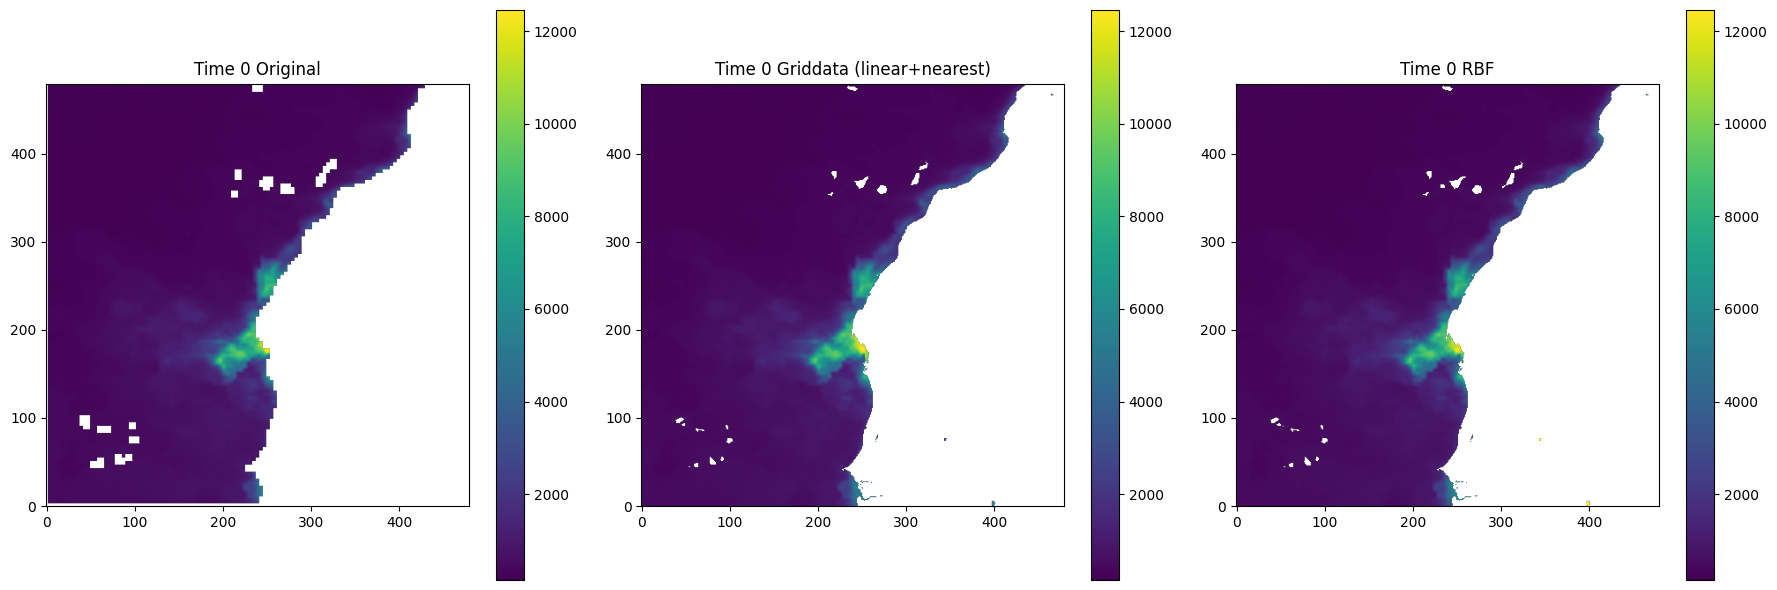

📌 VARIACIÓN EN INTERPOLACIONES (sobre datos faltantes oceánicos):
- Griddata -> N. valores únicos: 2053
- RBF      -> N. valores únicos: 3315
✅ Griddata ha generado variación.
✅ RBF ha generado variación.
📊 VARIACIÓN EN ZONAS OCEÁNICAS INTERPOLADAS

🔹 Interpolación Griddata (e.g., 'nearest' o 'linear'):
  - Min: 156.57555616033403
  - Max: 11469.574631530386
  - Mean: 785.835553517359
  - Std: 1469.5552882372558
  - Range: 11312.999075370051
  - Unique_vals: 2054

🔹 Interpolación RBF:
  - Min: 154.5055390377729
  - Max: 19693.603461017075
  - Mean: 843.2776752469556
  - Std: 1930.2758998691058
  - Range: 19539.0979219793
  - Unique_vals: 3316


C:\Users\imano\AppData\Local\Temp\ipykernel_52088\2178172602.py:36: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\imano\AppData\Local\Temp\ipykernel_52088\2178172602.py:36: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\imano\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\imano\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


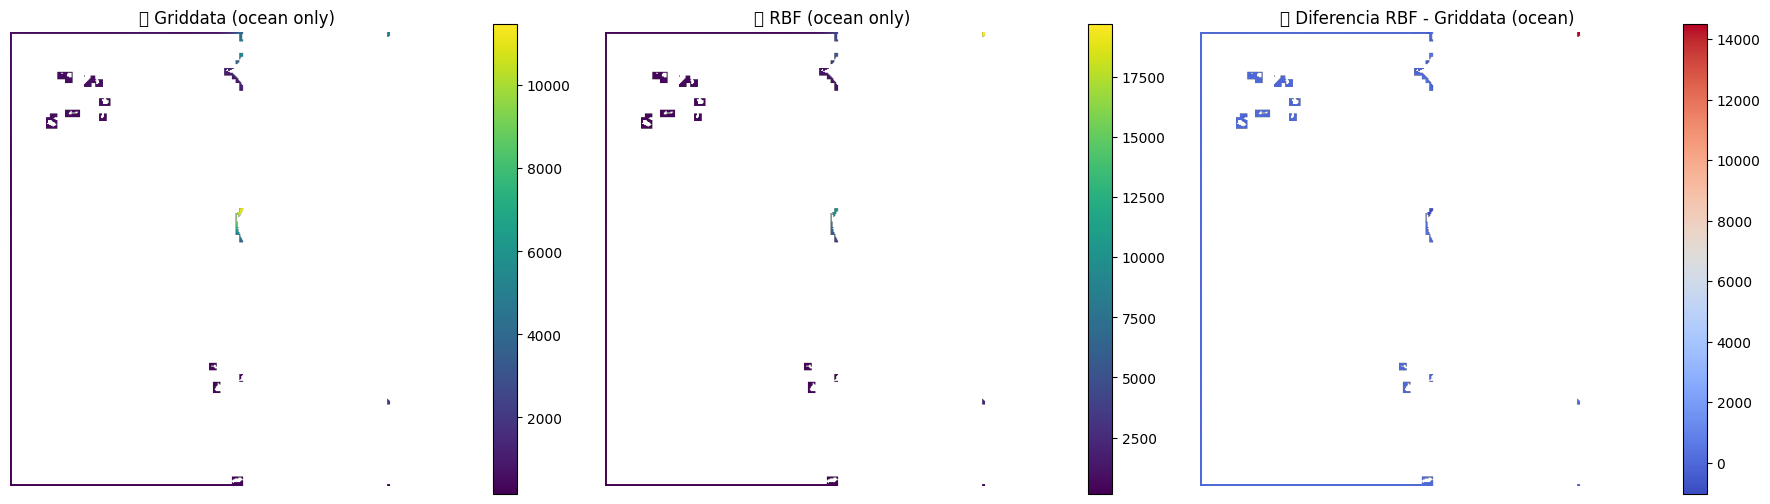

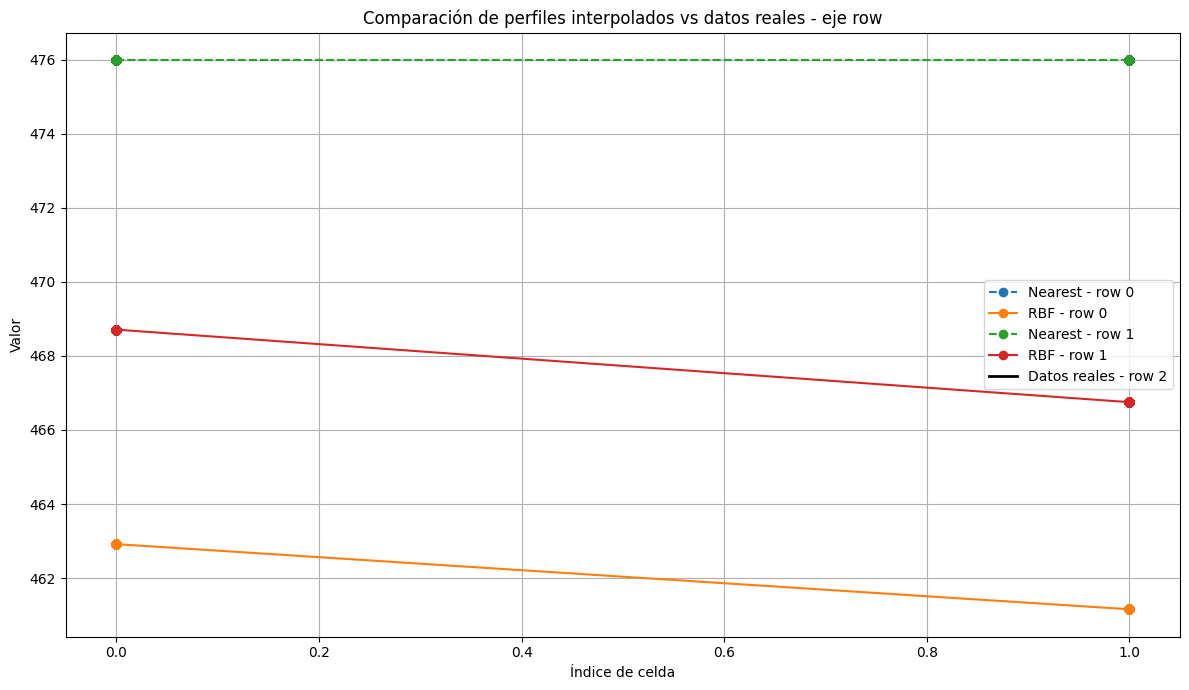

Total de puntos is_ocean: 144346
Total de puntos is_ocean en el dataset interpolado nearest y linear: 144346
Total de puntos npp que no son NaN en el dataset interpolado nearest y linear: 230400
Total de puntos is_ocean en el dataset interpolado RBF: 144346
---------------------------------------------


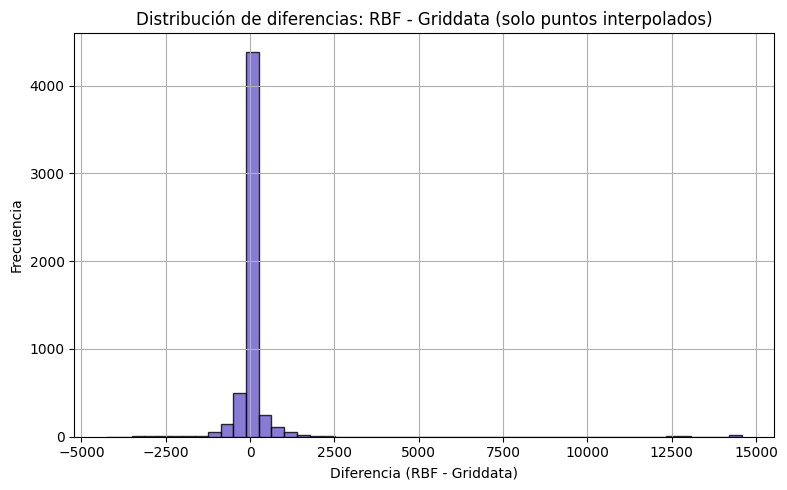

In [18]:
import xarray as xr
import numpy as np

ds_original = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\final_with_isOcean.nc")
ds_griddata = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\npp_interpolated.nc")
ds_rbf = xr.open_dataset(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\npp_rbf_interpolated.nc")

# Extraer el mismo tiempo t
t = 0
original = ds_original['npp'].values[t]
interp_grid = ds_griddata['npp'].values[t]
interp_rbf = ds_rbf['npp'].values[t]

latitudes = ds_original['latitude'].values
longitudes = ds_original['longitude'].values

# Comparación visual
plot_interpolations(original, interp_grid, interp_rbf, latitudes, longitudes, title_prefix=f"Time {t}")

# Crear una máscara de comparación (por ejemplo, quitar 10% de los puntos válidos)
valid_mask = ~np.isnan(original)
sample_indices = np.random.choice(np.where(valid_mask.ravel())[0], size=int(0.1 * np.sum(valid_mask)), replace=False)
comparison_mask = np.zeros_like(original, dtype=bool).ravel()
comparison_mask[sample_indices] = True
comparison_mask = comparison_mask.reshape(original.shape)

is_ocean_mask = ds_original['is_ocean'].values[t]
is_ocean_mask = is_ocean_mask.astype(bool)

# Evaluación de errores
compare_missing_ocean_variation(original, interp_grid, interp_rbf, is_ocean_mask)

compare_ocean_interpolation_variation(original, interp_grid, interp_rbf, is_ocean_mask)

plot_ocean_interpolation_variation(original, interp_grid, interp_rbf, is_ocean_mask)

is_ocean_mask = ds_original['is_ocean'].values

# Si tiene solo 1 dimensión, conviértelo a 2D con la forma correcta
if is_ocean_mask.ndim == 1:
    is_ocean_mask = is_ocean_mask.reshape(original.shape)



plot_multiple_profiles(original, interp_grid, interp_rbf, is_ocean_mask, indices=[0, 1], reference_index=2, axis='row')



# Cálculo de puntos is_ocean
is_ocean_mask = ds_original['is_ocean'].values
is_ocean_mask = is_ocean_mask.astype(bool)
print(f"Total de puntos is_ocean: {np.sum(is_ocean_mask)}")

# Cálculo de puntos is_ocean en el dataset interpolado nearest y linear
is_ocean_mask_griddata = ds_griddata['is_ocean'].values
is_ocean_mask_griddata = is_ocean_mask_griddata.astype(bool)
print(f"Total de puntos is_ocean en el dataset interpolado nearest y linear: {np.sum(is_ocean_mask_griddata)}")

# Cálculo de puntos de npp que no son NaN en el dataset interpolado nearest y linear
npp_mask_griddata = ds_griddata['npp'].values[t]
npp_mask_griddata = npp_mask_griddata.astype(bool)
print(f"Total de puntos npp que no son NaN en el dataset interpolado nearest y linear: {np.sum(npp_mask_griddata)}")

# Cálculo de puntos is_ocean en el dataset interpolado RBF
is_ocean_mask_rbf = ds_rbf['is_ocean'].values
is_ocean_mask_rbf = is_ocean_mask_rbf.astype(bool)
print(f"Total de puntos is_ocean en el dataset interpolado RBF: {np.sum(is_ocean_mask_rbf)}")

print("---------------------------------------------")

# Creamos una máscara para seleccionar solo los puntos en el mar que fueron interpolados
mask_valid = np.isnan(original) & is_ocean_mask

# Calculamos la diferencia entre interpolaciones solo donde no hay datos originales
diff = interp_rbf[mask_valid] - interp_grid[mask_valid]

# Visualizamos el histograma
plt.figure(figsize=(8, 5))
plt.hist(diff, bins=50, color='slateblue', alpha=0.8, edgecolor='black')
plt.title("Distribución de diferencias: RBF - Griddata (solo puntos interpolados)")
plt.xlabel("Diferencia (RBF - Griddata)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()



### Datos in situ

In [ ]:
!"C:\Users\imano\AppData\Local\Programs\Python\Python313\python.exe" -m pip install openpyxl

In [1]:
import pandas as pd
import numpy as np
from netCDF4 import Dataset, date2num
from datetime import datetime

# Cargar el archivo Excel, omitiendo la fila de unidades (segunda fila)
df = pd.read_excel(r"C:\Users\imano\Downloads\Template_PE_data.xlsx", skiprows=[1])

# Asegurarse de que los nombres de columna estén correctos
df.columns = [col.strip() for col in df.columns]

# Crear la columna de fechas
df['date'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])

# Eliminar filas con datos faltantes (opcional)
df = df.dropna(subset=['LAT', 'LON', 'PP (14C)', 'date'])

# Convertir datos a arrays
lats = df['LAT'].values
lons = df['LON'].values
pps = df['PP (14C)'].values
times = df['date'].values

times = [pd.to_datetime(t).to_pydatetime() for t in times]

# Crear archivo NetCDF
ncfile = Dataset('PP_data.nc', mode='w', format='NETCDF4')

# Crear dimensiones (una dimensión por muestra)
n = len(df)
ncfile.createDimension('obs', n)

# Crear variables
lat = ncfile.createVariable('latitude', np.float32, ('obs',))
lon = ncfile.createVariable('longitude', np.float32, ('obs',))
pp = ncfile.createVariable('PP_14C', np.float32, ('obs',))
time = ncfile.createVariable('time', np.float64, ('obs',))

# Definir atributos
lat.units = 'degrees_north'
lon.units = 'degrees_east'
pp.units = 'mg C m-3 d-1'  # Ajusta según la unidad de la segunda fila en Excel
time.units = 'days since 1970-01-01 00:00:00'
time.calendar = 'standard'

# Rellenar variables
lat[:] = lats
lon[:] = lons
pp[:] = pps
time[:] = date2num(times, units=time.units, calendar=time.calendar)

# Atributos globales opcionales
ncfile.description = 'Datos de Producción Primaria (14C)'
ncfile.history = f'Creado {datetime.now()}'
ncfile.source = 'Template_PE_data.xlsx'

# Cerrar archivo
ncfile.close()

print("Archivo NetCDF creado: PP_data.nc")


Archivo NetCDF creado: PP_data.nc


### Lunes 26

In [ ]:
import pandas as pd

def index_to_letters(i):
    """Convierte un índice entero en letras estilo Excel: 0 → A, 1 → B, ..., 25 → Z, 26 → AA, etc."""
    result = ""
    i += 1  # Excel-style index starts at 1
    while i > 0:
        i -= 1
        result = chr(65 + (i % 26)) + result
        i //= 26
    return result

def generate_grid(input_csv, output_tsv):
    """Genera un archivo grid.tsv con las coordenadas ordenadas correctamente"""
    
    # Cargar CSV con la información de las celdas
    df = pd.read_csv(input_csv)
    
    # Verificar columnas necesarias
    if not all(col in df.columns for col in ["latitude", "longitude"]):
        raise ValueError("El archivo CSV debe contener columnas 'latitude' y 'longitude'")
    
    # Obtener valores únicos ordenados
    lats = sorted(df["latitude"].unique(), reverse=True)  # De norte a sur
    lons = sorted(df["longitude"].unique())              # De oeste a este
    
    # Verificar dimensiones
    if len(lats) != 480 or len(lons) != 480:
        print(f"Advertencia: Se esperaban 480x480 celdas, pero hay {len(lats)}x{len(lons)}")
        print("Continuando con las dimensiones disponibles...")
    
    # Generar la grilla
    rows = []
    for i, lat in enumerate(lats):
        row_letter = index_to_letters(i)
        for j, lon in enumerate(lons):
            rows.append({
                "tile": f"{row_letter}{j+1}",
                "lat": lat,
                "lon": lon
            })
    
    # Crear y guardar el DataFrame
    grid_df = pd.DataFrame(rows)
    grid_df.to_csv(output_tsv, sep="\t", index=False, header=False)
    print(f"Grid generado exitosamente en {output_tsv}")

# Uso del script
if __name__ == "__main__":
    input_path = r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\npp_interpolated.csv"
    output_path = r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\grid.tsv"
    
    generate_grid(input_path, output_path)

In [ ]:
import pandas as pd

# Cargar archivo generado previamente
df = pd.read_csv(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\measurements_with_neighbors.tsv", sep="\t")

# Reemplazar columna 'instant' con formato YYYYMM
df["date"] = pd.to_datetime(df["instant"]).dt.strftime("%Y%m")

# Mover 'date' al principio y eliminar 'instant'
df.drop(columns="instant", inplace=True)
cols = ["date", "tile"] + [col for col in df.columns if col not in ["date", "tile"]]
df = df[cols]

# Reorganizar columnas por variable agrupando vecinos
from collections import defaultdict

# Agrupar columnas por variable base
grouped = defaultdict(list)
for col in df.columns:
    if col in ["date", "tile"]:
        continue
    if ":" in col:
        base, suffix = col.split(":")
        grouped[base].append((suffix, col))  # Ej: ('left', 'env.sst:left')
    else:
        grouped[col].insert(0, ("", col))  # Principal primero

# Construir nuevo orden de columnas
ordered_columns = ["date", "tile"]
for var in sorted(grouped.keys()):
    ordered_columns += [col for _, col in sorted(grouped[var], key=lambda x: (x[0] != "", x[0]))]  # "" (original) primero

# Reordenar DataFrame
df = df[ordered_columns]

# Guardar archivo final
df.to_csv(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\measurements_with_neighbors_ordered.tsv", sep="\t", index=False)


In [ ]:
import pandas as pd
import re

# Cargar el TSV original
df = pd.read_csv(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\measurements.tsv", sep="\t")

# Filtrar solo para la fecha 2002-08-01
df = df[df["ts"] == "2002-08-01"].copy()

# Crear índice rápido tile -> fila
tile_data = df.set_index("tile")

# Columnas de variables (quitamos ts y tile)
vars_to_expand = [col for col in df.columns if col not in ("ts", "tile")]

# Funciones para convertir tile a coordenadas y viceversa
def parse_tile(tile):
    match = re.match(r"([A-Z]+)(\d+)", tile)
    if not match:
        return None
    row_letters, col = match.groups()
    row = sum([(ord(c) - ord('A') + 1) * (26 ** i) for i, c in enumerate(reversed(row_letters))])
    return row, int(col)

def make_tile(row, col):
    if row < 1 or col < 1:
        return None
    letters = ""
    while row > 0:
        row, rem = divmod(row - 1, 26)
        letters = chr(ord('A') + rem) + letters
    return f"{letters}{col}"

# Preparar nuevas filas
rows = []

for tile in df["tile"]:
    row_letter, col_number = parse_tile(tile)
    base = {
        "date": "200208",
        "cell": tile
    }

    # Añadir valores propios
    for var in vars_to_expand:
        base[var] = tile_data.at[tile, var] if tile in tile_data.index else None

    # Direcciones vecinas
    directions = {
        "left": (row_letter, col_number - 1),
        "right": (row_letter, col_number + 1),
        "up": (row_letter + 1, col_number),
        "down": (row_letter - 1, col_number),
    }

    for direction, (r, c) in directions.items():
        neighbor_tile = make_tile(r, c)
        if neighbor_tile and neighbor_tile in tile_data.index:
            for var in vars_to_expand:
                base[f"{var}:{direction}"] = tile_data.at[neighbor_tile, var]
        else:
            for var in vars_to_expand:
                base[f"{var}:{direction}"] = None

    rows.append(base)

# Crear nuevo DataFrame
output_df = pd.DataFrame(rows)

# Ordenar columnas como: date, cell, var, var:left, var:right, ...
ordered_columns = ["date", "cell"]
for var in vars_to_expand:
    ordered_columns.append(var)
    for d in ["left", "right", "up", "down"]:
        ordered_columns.append(f"{var}:{d}")

# Reordenar y guardar
output_df = output_df[ordered_columns]
output_df.to_csv(r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\measurements_august_with_neighbors.tsv", sep="\t", index=False)


In [ ]:
import pandas as pd
import re
from datetime import datetime, timedelta
import os

def parse_tile(tile):
    """Convierte un tile (ej. 'A1') en coordenadas (fila, columna)"""
    match = re.match(r"([A-Z]+)(\d+)", tile)
    if not match:
        return None
    row_letters, col = match.groups()
    row = sum([(ord(c) - ord('A') + 1) * (26 ** i) for i, c in enumerate(reversed(row_letters))])
    return row, int(col)

def make_tile(row, col):
    """Convierte coordenadas (fila, columna) en tile (ej. 'A1')"""
    if row < 1 or col < 1:
        return None
    letters = ""
    while row > 0:
        row, rem = divmod(row - 1, 26)
        letters = chr(ord('A') + rem) + letters
    return f"{letters}{col}"

def generate_monthly_files(input_tsv, output_dir):
    """Genera archivos TSV mensuales con datos de vecinos"""
    
    # Cargar el TSV original
    df = pd.read_csv(input_tsv, sep="\t")
    
    # Convertir ts a datetime
    df['ts'] = pd.to_datetime(df['ts'])
    
    # Columnas de variables (quitamos ts y tile)
    vars_to_expand = [col for col in df.columns if col not in ("ts", "tile")]
    
    # Crear rango de fechas mensuales (2002-08 a 2023-12)
    start_date = datetime(2002, 8, 1)
    end_date = datetime(2023, 12, 1)
    current_date = start_date
    
    while current_date <= end_date:
        # Filtrar datos para el mes actual (usando el año y mes)
        monthly_df = df[(df["ts"].dt.year == current_date.year) & 
                       (df["ts"].dt.month == current_date.month)].copy()
        
        if not monthly_df.empty:
            # Crear índice rápido tile -> fila
            tile_data = monthly_df.set_index("tile")
            
            # Preparar nuevas filas
            rows = []
            
            for tile in monthly_df["tile"]:
                row_letter, col_number = parse_tile(tile)
                base = {
                    "date": current_date.strftime("%Y%m"),
                    "cell": tile
                }

                # Añadir valores propios
                for var in vars_to_expand:
                    base[var] = tile_data.at[tile, var] if tile in tile_data.index else None

                # Direcciones vecinas
                directions = {
                    "left": (row_letter, col_number - 1),
                    "right": (row_letter, col_number + 1),
                    "up": (row_letter + 1, col_number),
                    "down": (row_letter - 1, col_number),
                }

                for direction, (r, c) in directions.items():
                    neighbor_tile = make_tile(r, c)
                    if neighbor_tile and neighbor_tile in tile_data.index:
                        for var in vars_to_expand:
                            base[f"{var}:{direction}"] = tile_data.at[neighbor_tile, var]
                    else:
                        for var in vars_to_expand:
                            base[f"{var}:{direction}"] = None

                rows.append(base)

            # Crear nuevo DataFrame
            output_df = pd.DataFrame(rows)
            
            # Ordenar columnas
            ordered_columns = ["date", "cell"]
            for var in vars_to_expand:
                ordered_columns.append(var)
                for d in ["left", "right", "up", "down"]:
                    ordered_columns.append(f"{var}:{d}")
            
            # Reordenar y guardar
            output_df = output_df[ordered_columns]
            
            # Nombre del archivo de salida (ej: measurements_200208_with_neighbors.tsv)
            output_filename = f"measurements_{current_date.strftime('%Y%m')}_with_neighbors.tsv"
            output_path = os.path.join(output_dir, output_filename)
            output_df.to_csv(output_path, sep="\t", index=False)
            
            print(f"Archivo generado: {output_filename}")
        
        # Avanzar al siguiente mes
        if current_date.month == 12:
            current_date = current_date.replace(year=current_date.year + 1, month=1)
        else:
            current_date = current_date.replace(month=current_date.month + 1)

if __name__ == "__main__":
    input_path = r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\measurements.tsv"
    output_dir = r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\monthly_neighbors"
    
    # Crear directorio de salida si no existe
    os.makedirs(output_dir, exist_ok=True)
    
    generate_monthly_files(input_path, output_dir)
    print("Proceso completado. Archivos generados en:", output_dir)

In [2]:
import pandas as pd

chunksize = 10000
tsv_file = r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\monthly_neighbors\measurements.tsv"
csv_file = r"C:\Users\imano\Desktop\4o CARRERA\TFG\cuadernos\refactor\miercoles\monthly_neighbors\measurements.csv"

reader = pd.read_csv(tsv_file, sep='\t', chunksize=chunksize)

for i, chunk in enumerate(reader):
    if i == 0:
        chunk.to_csv(csv_file, index=False, mode='w')  # escribe con cabecera
    else:
        chunk.to_csv(csv_file, index=False, mode='a', header=False)  # añade sin cabecera


In [ ]:
import pandas as pd
import re
from datetime import datetime, timedelta
import os

def parse_tile(tile):
    """Convierte un tile (ej. 'A1') en coordenadas (fila, columna)"""
    match = re.match(r"([A-Z]+)(\d+)", tile)
    if not match:
        return None
    row_letters, col = match.groups()
    row = sum([(ord(c) - ord('A') + 1) * (26 ** i) for i, c in enumerate(reversed(row_letters))])
    return row, int(col)

def make_tile(row, col):
    """Convierte coordenadas (fila, columna) en tile (ej. 'A1')"""
    if row < 1 or col < 1:
        return None
    letters = ""
    while row > 0:
        row, rem = divmod(row - 1, 26)
        letters = chr(ord('A') + rem) + letters
    return f"{letters}{col}"

def generate_monthly_files(input_tsv, output_dir):
    """Genera archivos CSV mensuales con datos de vecinos"""
    
    # Cargar el TSV original
    df = pd.read_csv(input_tsv, sep="\t")
    
    # Convertir ts a datetime
    df['ts'] = pd.to_datetime(df['ts'])
    
    # Columnas de variables (quitamos ts y tile)
    vars_to_expand = [col for col in df.columns if col not in ("ts", "tile")]
    
    # Crear rango de fechas mensuales (2002-08 a 2023-12)
    start_date = datetime(2002, 8, 1)
    end_date = datetime(2023, 12, 1)
    current_date = start_date
    
    while current_date <= end_date:
        # Filtrar datos para el mes actual (usando el año y mes)
        monthly_df = df[(df["ts"].dt.year == current_date.year) & 
                       (df["ts"].dt.month == current_date.month)].copy()
        
        if not monthly_df.empty:
            # Crear índice rápido tile -> fila
            tile_data = monthly_df.set_index("tile")
            
            # Preparar nuevas filas
            rows = []
            
            for tile in monthly_df["tile"]:
                row, col = parse_tile(tile)
                base = {
                    "date": current_date.strftime("%Y-%m-%dT%H:%M:%SZ"),
                    "cell": tile
                }

                # Añadir valores propios
                for var in vars_to_expand:
                    base[var] = tile_data.at[tile, var] if tile in tile_data.index else None

                # Direcciones vecinas CORREGIDAS:
                # left: misma fila, columna - 1
                # right: misma fila, columna + 1
                # up: fila + 1, misma columna (norte)
                # down: fila - 1, misma columna (sur)
                # directions = {
                #     "left": (row, col - 1),
                #     "right": (row, col + 1),
                #     "up": (row + 1, col),    # Norte (A2 está arriba de A1)
                #     "down": (row - 1, col),   # Sur (A1 está abajo de A2)
                # }
                directions = {
                    "down": (row, col - 1),
                    "up": (row, col + 1),
                    "right": (row + 1, col),    # Norte (A2 está arriba de A1)
                    "left": (row - 1, col),   # Sur (A1 está abajo de A2)
                }

                for direction, (r, c) in directions.items():
                    neighbor_tile = make_tile(r, c)
                    if neighbor_tile and neighbor_tile in tile_data.index:
                        for var in vars_to_expand:
                            base[f"{var}:{direction}"] = tile_data.at[neighbor_tile, var]
                    else:
                        for var in vars_to_expand:
                            base[f"{var}:{direction}"] = None

                rows.append(base)

            # Crear nuevo DataFrame
            output_df = pd.DataFrame(rows)
            
            # Ordenar columnas
            ordered_columns = ["date", "cell"]
            for var in vars_to_expand:
                ordered_columns.append(var)
                for d in ["left", "right", "up", "down"]:
                    ordered_columns.append(f"{var}:{d}")
            
            # Reordenar y guardar
            output_df = output_df[ordered_columns]
            
            # Nombre del archivo de salida
            output_filename = f"measurements_{current_date.strftime('%Y%m')}_with_neighbors.csv"
            output_path = os.path.join(output_dir, output_filename)
            output_df.to_csv(output_path, sep=",", index=False)
            
            print(f"Archivo generado: {output_filename}")
        
        # Avanzar al siguiente mes
        if current_date.month == 12:
            current_date = current_date.replace(year=current_date.year + 1, month=1)
        else:
            current_date = current_date.replace(month=current_date.month + 1)

if __name__ == "__main__":
    input_path = r"C:\Users\imano\Desktop\4o CARRERA\TFG\project\data\dataset_region.tsv"
    output_dir = r"C:\Users\imano\Desktop\4o CARRERA\TFG\project\data\monthly_neighbors"
    
    # Crear directorio de salida si no existe
    os.makedirs(output_dir, exist_ok=True)
    
    generate_monthly_files(input_path, output_dir)
    print("Proceso completado. Archivos generados en:", output_dir)